In [11]:
import pandas as pd
from pandas_datareader import data as pdr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime

from scipy.stats import linregress
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import warnings
# Suppress the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, message="The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.")

# %%
def load_data(ticker='SPY', start='2008-01-01', end=None):
    """
    Load historical data for a given ticker using yfinance.
    """
    if end is None:
        end = datetime.now().strftime('%Y-%m-%d')
    df = yf.download(ticker, start=start, end=end)
    return df

def extract_monthly_data(seasonality_table, month):
    """
    Extract data for a specific month.
    """
    return seasonality_table.loc[month]

def visualize_monthly_data(monthly_data, month):
    """
    Visualize the extracted data for the selected month.
    """
    plt.figure(figsize=(10, 6))
    plt.bar(monthly_data.index, monthly_data.values, color='dodgerblue')
    plt.xlabel('Year')
    plt.ylabel(f'Average {month} Return (%)')
    plt.title(f'Average {month} Returns Over the Years')
    plt.xticks(rotation=45)
    plt.show()

def perform_quantitative_analysis(monthly_data, month):
    """
    Perform quantitative analysis on the extracted monthly data.
    """
    mean_return = monthly_data.mean()
    std_return = monthly_data.std()
    highest_return_year = monthly_data.idxmax()
    highest_return_value = monthly_data.max()
    lowest_return_year = monthly_data.idxmin()
    lowest_return_value = monthly_data.min()

    print(f"Mean {month} Return: {mean_return:.2f}%")
    print(f"Standard Deviation of {month} Returns: {std_return:.2f}%")
    print(f"Highest {month} Return: {highest_return_value:.2f}% in {highest_return_year}")
    print(f"Lowest {month} Return: {lowest_return_value:.2f}% in {lowest_return_year}")

    # Determine Overall Trend
    years = monthly_data.index.astype(int)
    returns = monthly_data.values
    if len(set(returns)) > 1:  # Check for variance in data
        slope, intercept, r_value, p_value, std_err = linregress(years, returns)

        plt.figure(figsize=(10, 6))
        plt.bar(monthly_data.index, monthly_data.values, color='dodgerblue', label=f'{month} Return')
        plt.plot(monthly_data.index, intercept + slope*years, 'r', label=f'Trend Line (slope={slope:.2f})')
        plt.xlabel('Year')
        plt.ylabel(f'Average {month} Return (%)')
        plt.title(f'Average {month} Returns Over the Years with Trend Line')
        plt.legend()
        plt.xticks(rotation=45)
        plt.show()

        print(f"Trend Line Slope: {slope:.2f}% per year")
        print(f"R-squared: {r_value**2:.2f}")
    else:
        print(f"No variance in {month} data to compute trend line.")

def calculate_technical_indicators(df):
    """
    Calculate RSI, Bollinger Bands, and MACD for the given dataframe.
    """
    # Calculate RSI
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    RS = gain / loss
    df['RSI'] = 100 - (100 / (1 + RS))

    # Calculate Bollinger Bands
    df['20 Day MA'] = df['Close'].rolling(window=20).mean()
    df['20 Day STD'] = df['Close'].rolling(window=20).std()
    df['Upper Band'] = df['20 Day MA'] + (df['20 Day STD'] * 2)
    df['Lower Band'] = df['20 Day MA'] - (df['20 Day STD'] * 2)

    # Calculate MACD
    df['12 EMA'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['26 EMA'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['12 EMA'] - df['26 EMA']
    df['Signal Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

    print("Technical Indicators:\n", df[['RSI', 'Upper Band', 'Lower Band', 'MACD', 'Signal Line']].head())
    return df

def plot_monthly_technical_indicators(df):
    """
    Plot RSI, Bollinger Bands, and MACD for the given dataframe.
    """
    plt.figure(figsize=(14, 10))

    # Plot Close Price and Bollinger Bands
    plt.subplot(4, 1, 1)
    plt.plot(df['Close'], label='Close Price')
    plt.plot(df['Upper Band'], label='Upper Bollinger Band', linestyle='--', color='r')
    plt.plot(df['Lower Band'], label='Lower Bollinger Band', linestyle='--', color='b')
    plt.fill_between(df.index, df['Upper Band'], df['Lower Band'], alpha=0.1)
    plt.title('Monthly Close Price and Bollinger Bands')
    plt.legend()

    # Plot RSI
    plt.subplot(4, 1, 2)
    plt.plot(df['RSI'], label='RSI', color='purple')
    plt.axhline(70, linestyle='--', alpha=0.5, color='r')
    plt.axhline(30, linestyle='--', alpha=0.5, color='g')
    plt.title('Monthly Relative Strength Index (RSI)')
    plt.legend()

    # Plot MACD
    plt.subplot(4, 1, 3)
    plt.plot(df['MACD'], label='MACD', color='g')
    plt.plot(df['Signal Line'], label='Signal Line', color='orange')
    plt.fill_between(df.index, df['MACD'] - df['Signal Line'], 0, alpha=0.2, color='grey')
    plt.title('Monthly MACD and Signal Line')
    plt.legend()

    plt.tight_layout()
    plt.show()

def fetch_fed_data(series, start_date='2008-01-01'):
    """
    Fetch macroeconomic data from FRED.
    """
    return pdr.get_data_fred(series, start=start_date)

def merge_macro_data(financial_df, macro_df):
    """
    Merge financial data with macroeconomic data.
    """
    macro_df = macro_df.resample('M').ffill()  # Ensure macro data is also monthly
    merged_df = financial_df.merge(macro_df, left_index=True, right_index=True, how='inner')
    print("Merged Data:\n", merged_df.head())
    return merged_df

def plot_with_macro_data(merged_df):
    """
    Plot financial indicators with macroeconomic data.
    """
    fig, axs = plt.subplots(4, 1, figsize=(14, 12))

    # Plot Close Price and Bollinger Bands
    axs[0].plot(merged_df['Close'], label='Close Price')
    axs[0].plot(merged_df['Upper Band'], label='Upper Bollinger Band', linestyle='--', color='r')
    axs[0].plot(merged_df['Lower Band'], label='Lower Bollinger Band', linestyle='--', color='b')
    axs[0].fill_between(merged_df.index, merged_df['Upper Band'], merged_df['Lower Band'], alpha=0.1)
    axs[0].set_title('Monthly Close Price and Bollinger Bands')
    axs[0].legend()

    # Plot RSI
    axs[1].plot(merged_df['RSI'], label='RSI', color='purple')
    axs[1].axhline(70, linestyle='--', alpha=0.5, color='r')
    axs[1].axhline(30, linestyle='--', alpha=0.5, color='g')
    axs[1].set_title('Monthly Relative Strength Index (RSI)')
    axs[1].legend()

    # Plot MACD
    axs[2].plot(merged_df['MACD'], label='MACD', color='g')
    axs[2].plot(merged_df['Signal Line'], label='Signal Line', color='orange')
    axs[2].fill_between(merged_df.index, merged_df['MACD'] - merged_df['Signal Line'], 0, alpha=0.2, color='grey')
    axs[2].set_title('Monthly MACD and Signal Line')
    axs[2].legend()

    # Plot Fed Funds Rate
    axs[3].plot(merged_df['FEDFUNDS'], label='Federal Funds Rate', color='blue')
    axs[3].set_title('Federal Funds Rate')
    axs[3].legend()

    plt.tight_layout()
    plt.show()

# Define the half-Kelly criterion function
def half_kelly_criterion(mean_return, std_return):
    win_prob = (mean_return / std_return) ** 2 / ((mean_return / std_return) ** 2 + 1)
    loss_prob = 1 - win_prob
    odds = mean_return / std_return
    kelly_fraction = (win_prob - loss_prob) / odds
    half_kelly_fraction = kelly_fraction / 2
    return half_kelly_fraction

# Define portfolio return and variance calculations
def calculate_portfolio_return(weights, returns):
    return np.dot(weights, returns)

def calculate_portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

# Objective function to maximize portfolio return
def objective_function(weights):
    portfolio_return = calculate_portfolio_return(weights, returns)
    portfolio_variance = calculate_portfolio_variance(weights, cov_matrix)
    portfolio_std_dev = np.sqrt(portfolio_variance)
    return -portfolio_return  # Negative for minimization

def apply_kelly_method(mean_return, std_dev, win_prob):
    """Calculate the Kelly criterion for position sizing."""
    b = mean_return / std_dev  # Assuming b is the edge ratio
    kelly_fraction = win_prob - ((1 - win_prob) / b)
    return kelly_fraction

def machine_learning_analysis(df):
    """Perform machine learning analysis using RandomForest and return the model and accuracy."""
    df['Target'] = (df['Return'] > 0).astype(int)  # Binary classification: 1 if return is positive, 0 otherwise
    features = ['Adj Close', 'Return']  # Example features; you can add more technical indicators
    X = df[features].shift(1)  # Shift features to avoid look-ahead bias
    y = df['Target'].shift(1)
    # Drop rows with NaN values to ensure consistent lengths
    X, y = X.dropna(), y.dropna()
    X, y = X.align(y, join='inner', axis=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy: {accuracy:.2f}")
    return model, accuracy

def create_summary_csv(tickers, start_date, end_date, filename='summary.csv'):
    """Create a CSV file with mean, std, count, positive_prob, and Kelly size for all assets."""
    summary_data = []
    for ticker in tickers:
        df = load_price_data(ticker, start=start_date, end=end_date)
        if isinstance(df, pd.Series):
            df = df.to_frame(name='Adj Close')
        if 'Adj Close' not in df.columns:
            print(f"Column 'Adj Close' not found in the data for {ticker}. Available columns: {df.columns}")
            continue
        df = calculate_returns(df)
        seasonality_table = create_seasonality_table(df)
        for month, stats in seasonality_table.iterrows():
            mean_return = stats['mean']
            std_dev = stats['std']
            count = stats['count']
            positive_prob = stats['positive_prob']
            kelly_size = apply_kelly_method(mean_return, std_dev, positive_prob)
            summary_data.append({
                'Ticker': ticker,
                'Month': month,
                'Mean Return': mean_return,
                'Standard Deviation': std_dev,
                'Count': count,
                'Positive Probability': positive_prob,
                'Kelly Size': kelly_size
            })
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_csv(filename, index=False)
    print(f"Summary CSV created: {filename}")

def analyze_ticker(ticker, start_date, end_date):
    df = load_price_data(ticker, start=start_date, end=end_date)
    if isinstance(df, pd.Series):
        df = df.to_frame(name='Adj Close')
    if 'Adj Close' not in df.columns:
        print(f"Column 'Adj Close' not found in the data for {ticker}. Available columns: {df.columns}")
        return
    df = calculate_returns(df)
    seasonality_table = create_seasonality_table(df)
    visualize_seasonality_table(seasonality_table, f'Seasonality of {ticker} Returns')
    display_all_monthly_statistics_with_kelly(df)
    # Machine Learning Analysis
    model, accuracy = machine_learning_analysis(df)

def seasonality_analysis(df):
    """Perform seasonality analysis."""
    return df.groupby(df.index.month)['Monthly Return'].agg(['mean', 'std', 'count', 'positive_prob'])

def plot_technical_indicators(df):
    """
    Plot RSI, Bollinger Bands, and MACD for the given dataframe.
    """
    plt.figure(figsize=(14, 10))

    # Plot Close Price and Bollinger Bands
    plt.subplot(3, 1, 1)
    plt.plot(df['Close'], label='Close Price')
    plt.plot(df['Upper Band'], label='Upper Bollinger Band', linestyle='--', color='r')
    plt.plot(df['Lower Band'], label='Lower Bollinger Band', linestyle='--', color='b')
    plt.fill_between(df.index, df['Upper Band'], df['Lower Band'], alpha=0.1)
    plt.title('Close Price and Bollinger Bands')
    plt.legend()

    # Plot RSI
    plt.subplot(3, 1, 2)
    plt.plot(df['RSI'], label='RSI', color='purple')
    plt.axhline(70, linestyle='--', alpha=0.5, color='r')
    plt.axhline(30, linestyle='--', alpha=0.5, color='g')
    plt.title('Relative Strength Index (RSI)')
    plt.legend()

    # Plot MACD
    plt.subplot(3, 1, 3)
    plt.plot(df['MACD'], label='MACD', color='g')
    plt.plot(df['Signal Line'], label='Signal Line', color='orange')
    plt.fill_between(df.index, df['MACD'] - df['Signal Line'], 0, alpha=0.2, color='grey')
    plt.title('MACD and Signal Line')
    plt.legend()

    plt.tight_layout()

def calculate_returns(df, period='ME'):
    """
    Calculate percentage returns based on the specified period.
    """
    df['Return'] = df['Close'].resample(period).ffill().pct_change() * 100
    df['Volume'] = df['Volume'].resample(period).sum()  # Sum volume for each period
    return df

def create_seasonality_table(df, column='Return'):
    """
    Create a pivot table for seasonality analysis.
    """
    seasonality_table = df.pivot_table(values=column, index=df.index.year, columns=df.index.month, aggfunc=np.mean)
    # Ensure all months are represented
    seasonality_table = seasonality_table.reindex(columns=range(1, 13))
    seasonality_table.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    seasonality_table = seasonality_table.transpose()
    return seasonality_table

def visualize_seasonality_table(seasonality_table, ticker):
    """
    Visualize the seasonality table using a heatmap.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(seasonality_table, annot=True, fmt=".2f", cmap='RdYlGn', center=0)
    plt.title(f'Seasonality of {ticker} Returns')
    plt.show()

# def display_all_monthly_statistics(seasonality_table, seasonality_volume_table, ticker):
#     """
#     Display the statistics for each month in the seasonality table.
#     """
#     months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
#     for month in months:
#         monthly_data = seasonality_table.loc[month]
#         monthly_volume = seasonality_volume_table.loc[month]
#         mean_return = monthly_data.mean()
#         std_return = monthly_data.std()
#         highest_return_year = monthly_data.idxmax()
#         highest_return_value = monthly_data.max()
#         lowest_return_year = monthly_data.idxmin()
#         lowest_return_value = monthly_data.min()
#         mean_volume = monthly_volume.mean()
#         highest_volume_year = monthly_volume.idxmax()
#         highest_volume_value = monthly_volume.max()
#         lowest_volume_year = monthly_volume.idxmin()
#         lowest_volume_value = monthly_volume.min()

#         print(f"{ticker} - {month} Statistics")
#         print(f"Mean {month} Return: {mean_return:.2f}%")
#         print(f"Standard Deviation of {month} Returns: {std_return:.2f}%")
#         print(f"Highest {month} Return: {highest_return_value:.2f}% in {highest_return_year}")
#         print(f"Lowest {month} Return: {lowest_return_value:.2f}% in {lowest_return_year}")
#         print(f"Mean {month} Volume: {mean_volume:.2f}")
#         print(f"Highest {month} Volume: {highest_volume_value:.2f} in {highest_volume_year}")
#         print(f"Lowest {month} Volume: {lowest_volume_value:.2f} in {lowest_volume_year}")
#         print()
        
def calculate_technical_indicators(df):
    # Calculate ATR
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    df['ATR'] = true_range.rolling(window=14).mean()
    
    # Calculate RSI
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    RS = gain / loss
    df['RSI'] = 100 - (100 / (1 + RS))
    
    # Calculate Bollinger Bands
    df['20 Day MA'] = df['Close'].rolling(window=20).mean()
    df['20 Day STD'] = df['Close'].rolling(window=20).std()
    df['Upper Band'] = df['20 Day MA'] + (df['20 Day STD'] * 2)
    df['Lower Band'] = df['20 Day MA'] - (df['20 Day STD'] * 2)
    
    # Calculate Ichimoku Cloud
    high_9 = df['High'].rolling(window=9).max()
    low_9 = df['Low'].rolling(window=9).min()
    df['tenkan_sen'] = (high_9 + low_9) / 2

    high_26 = df['High'].rolling(window=26).max()
    low_26 = df['Low'].rolling(window=26).min()
    df['kijun_sen'] = (high_26 + low_26) / 2

    df['senkou_span_a'] = ((df['tenkan_sen'] + df['kijun_sen']) / 2).shift(26)
    high_52 = df['High'].rolling(window=52).max()
    low_52 = df['Low'].rolling(window=52).min()
    df['senkou_span_b'] = ((high_52 + low_52) / 2).shift(26)

    df['chikou_span'] = df['Close'].shift(-26)
    
    return df

def display_all_monthly_statistics(df, ticker):
    df = calculate_technical_indicators(df)
    
    # Resample data to monthly
    df_monthly = df.resample('M').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum',
        'ATR': 'mean',
        'RSI': 'mean',
        '20 Day MA': 'mean',
        'Upper Band': 'mean',
        'Lower Band': 'mean',
        'tenkan_sen': 'mean',
        'kijun_sen': 'mean',
        'senkou_span_a': 'mean',
        'senkou_span_b': 'mean',
        'chikou_span': 'mean'
    })
    
    df_monthly['Return'] = df_monthly['Close'].pct_change() * 100
    
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    for month in range(1, 13):
        monthly_data = df_monthly[df_monthly.index.month == month]
        if monthly_data.empty:
            continue
        mean_return = monthly_data['Return'].mean()
        std_return = monthly_data['Return'].std()
        highest_return_year = monthly_data['Return'].idxmax().year
        highest_return_value = monthly_data['Return'].max()
        lowest_return_year = monthly_data['Return'].idxmin().year
        lowest_return_value = monthly_data['Return'].min()
        mean_volume = monthly_data['Volume'].mean()
        highest_volume_year = monthly_data['Volume'].idxmax().year
        highest_volume_value = monthly_data['Volume'].max()
        lowest_volume_year = monthly_data['Volume'].idxmin().year
        lowest_volume_value = monthly_data['Volume'].min()

        print(f"{ticker} - {months[month-1]} Statistics")
        print(f"Mean {months[month-1]} Return: {mean_return:.2f}%")
        print(f"Standard Deviation of {months[month-1]} Returns: {std_return:.2f}%")
        print(f"Highest {months[month-1]} Return: {highest_return_value:.2f}% in {highest_return_year}")
        print(f"Lowest {months[month-1]} Return: {lowest_return_value:.2f}% in {lowest_return_year}")
        print(f"Mean {months[month-1]} Volume: {mean_volume:.2f}")
        print(f"Highest {months[month-1]} Volume: {highest_volume_value:.2f} in {highest_volume_year}")
        print(f"Lowest {months[month-1]} Volume: {lowest_volume_value:.2f} in {lowest_volume_year}")
        print(f"Mean {months[month-1]} ATR: {monthly_data['ATR'].mean():.2f}")
        print(f"Mean {months[month-1]} RSI: {monthly_data['RSI'].mean():.2f}")
        print(f"Mean {months[month-1]} 20 Day MA: {monthly_data['20 Day MA'].mean():.2f}")
        print(f"Mean {months[month-1]} Upper Band: {monthly_data['Upper Band'].mean():.2f}")
        print(f"Mean {months[month-1]} Lower Band: {monthly_data['Lower Band'].mean():.2f}")
        print(f"Mean {months[month-1]} Tenkan-sen: {monthly_data['tenkan_sen'].mean():.2f}")
        print(f"Mean {months[month-1]} Kijun-sen: {monthly_data['kijun_sen'].mean():.2f}")
        print(f"Mean {months[month-1]} Senkou Span A: {monthly_data['senkou_span_a'].mean():.2f}")
        print(f"Mean {months[month-1]} Senkou Span B: {monthly_data['senkou_span_b'].mean():.2f}")
        print(f"Mean {months[month-1]} Chikou Span: {monthly_data['chikou_span'].mean():.2f}")

        # Add checks for conditions
        close_greater_than_rsi = (monthly_data['Close'] > monthly_data['RSI']).sum()
        close_greater_than_upper_band = (monthly_data['Close'] > monthly_data['Upper Band']).sum()
        high_greater_than_atr = (monthly_data['High'] > monthly_data['ATR']).sum()

        print(f"Number of days Close > RSI in {months[month-1]}: {close_greater_than_rsi}")
        print(f"Number of days Close > Upper Bollinger Band in {months[month-1]}: {close_greater_than_upper_band}")
        print(f"Number of days High > ATR in {months[month-1]}: {high_greater_than_atr}")
        print()


df = load_data('SPY')
display_all_monthly_statistics(df, 'SPY')


[*********************100%%**********************]  1 of 1 completed

SPY - Jan Statistics
Mean Jan Return: 0.36%
Standard Deviation of Jan Returns: 4.81%
Highest Jan Return: 8.01% in 2019
Lowest Jan Return: -8.21% in 2009
Mean Jan Volume: 2853895582.35
Highest Jan Volume: 6872039400.00 in 2009
Lowest Jan Volume: 1392003800.00 in 2020
Mean Jan ATR: 3.06
Mean Jan RSI: 56.76
Mean Jan 20 Day MA: 241.22
Mean Jan Upper Band: 249.02
Mean Jan Lower Band: 233.42
Mean Jan Tenkan-sen: 241.19
Mean Jan Kijun-sen: 246.59
Mean Jan Senkou Span A: 243.44
Mean Jan Senkou Span B: 238.36
Mean Jan Chikou Span: 244.76
Number of days Close > RSI in Jan: 17
Number of days Close > Upper Bollinger Band in Jan: 4
Number of days High > ATR in Jan: 17

SPY - Feb Statistics
Mean Feb Return: 0.42%
Standard Deviation of Feb Returns: 4.78%
Highest Feb Return: 5.62% in 2015
Lowest Feb Return: -10.74% in 2009
Mean Feb Volume: 2691990176.47
Highest Feb Volume: 7275092500.00 in 2009
Lowest Feb Volume: 1307806200.00 in 2021
Mean Feb ATR: 3.42
Mean Feb RSI: 57.83
Mean Feb 20 Day MA: 243.87
M


C:\Users\Administrator\AppData\Local\Temp\ipykernel_8944\1350205070.py:426: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M').agg({


# Display Monthly Seasonality

[*********************100%%**********************]  1 of 1 completed

Processing data for SPY...



C:\Users\Administrator\AppData\Local\Temp\ipykernel_8944\1350205070.py:327: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df['Return'] = df['Close'].resample(period).ffill().pct_change() * 100
C:\Users\Administrator\AppData\Local\Temp\ipykernel_8944\1350205070.py:328: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df['Volume'] = df['Volume'].resample(period).sum()  # Sum volume for each period
C:\Users\Administrator\AppData\Local\Temp\ipykernel_8944\1350205070.py:335: FutureWarning: The provided callable <function mean at 0x000002353F55DF80> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  seasonality_table = df.pivot_table(values=column, index=df.index.year, columns=df.index.month, aggfunc=np.mean)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_8

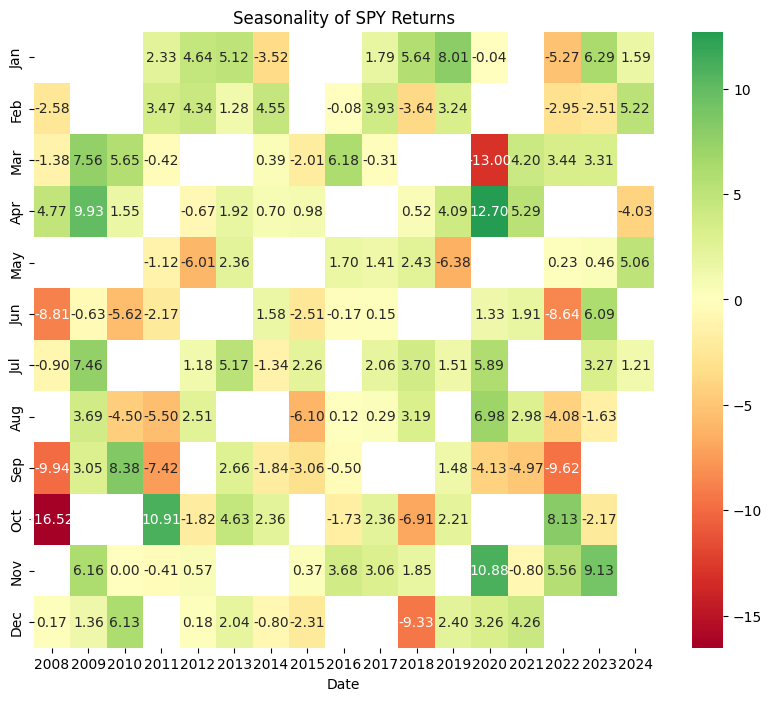

TypeError: display_all_monthly_statistics() takes 2 positional arguments but 3 were given

In [14]:
tickers = ['SPY', 'QQQ', 'DOW', 'SPYD']
for ticker in tickers:
    print(f"Processing data for {ticker}...")
    df = load_data(ticker)
    df = calculate_returns(df, period='M')
    seasonality_table = create_seasonality_table(df, column='Return')
    seasonality_volume_table = create_seasonality_table(df, column='Volume')
    visualize_seasonality_table(seasonality_table, ticker)
    display_all_monthly_statistics(seasonality_table, seasonality_volume_table, ticker)


In [13]:
# tickers = ['SPY', 'QQQ', 'DOW', 'SPYD']
# for ticker in tickers:
#     print(f"Processing data for {ticker}...")
#     df = load_data(ticker)
#     df = calculate_returns(df, period='M')
#     seasonality_table = create_seasonality_table(df, column='Return')
#     seasonality_volume_table = create_seasonality_table(df, column='Volume')
#     # visualize_seasonality_table(seasonality_table, ticker)
#     display_all_monthly_statistics(seasonality_table, seasonality_volume_table, ticker)


# 52 Week Seasonality with Kelly Method

In [6]:
def visualize_weekly_seasonality(tickers, start_date, end_date, triple_witching_weeks):
    """
    Visualizes the 52-week seasonality of a list of tickers.

    Parameters:
    tickers (list): List of ticker symbols to analyze.
    start_date (str): Start date for the historical data in "YYYY-MM-DD" format.
    end_date (str): End date for the historical data in "YYYY-MM-DD" format.
    triple_witching_weeks (list): List of week numbers that represent triple witching weeks.
    """
    
    # Download historical data for all tickers
    data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker')

    for ticker in tickers:
        # Calculate weekly returns and volume statistics
        df = data[ticker].copy()
        df['Return'] = df['Adj Close'].pct_change()
        df['Week_Number'] = df.index.isocalendar().week
        df['Year'] = df.index.year
        df['Ticker'] = ticker

        # Group data by year and week number
        weekly_data = df.groupby(['Year', 'Week_Number']).agg({
            'Return': 'sum',
            'Volume': 'mean'
        }).reset_index()
        weekly_data['Week'] = weekly_data['Week_Number'].astype(int)

        # Pivot the data for heatmap creation
        pivot_data = weekly_data.pivot(index="Week", columns="Year", values="Return")

        # Plot the heatmap with enhanced contrast and triple witching weeks highlighted
        plt.figure(figsize=(14, 8))
        sns.heatmap(pivot_data, annot=False, fmt=".2f", cmap="coolwarm", center=0, linewidths=.5, 
                    cbar_kws={'label': 'Weekly Return'})

        # Highlight Triple Witching Weeks
        for week in triple_witching_weeks:
            plt.axhline(y=week-0.5, color='yellow', linewidth=2)

        plt.title(f'Seasonality of {ticker} Returns')
        plt.show()


In [7]:
def export_weekly_seasonality_data(tickers, start_date, end_date, odds_ratio=2, output_dir='seasonality_data'):
    """
    Exports the 52-week seasonality data of a list of tickers to CSV files.

    Parameters:
    tickers (list): List of ticker symbols to analyze.
    start_date (str): Start date for the historical data in "YYYY-MM-DD" format.
    end_date (str): End date for the historical data in "YYYY-MM-DD" format.
    odds_ratio (float): The odds ratio for calculating the Kelly Ratio. Default is 2:1.
    output_dir (str): Directory where the CSV files will be saved.
    """
    
    # Create the output directory if it doesn't exist
    import os
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Download historical data for all tickers
    data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker')

    for ticker in tickers:
        # Calculate weekly returns and volume statistics
        df = data[ticker].copy()
        df['Return'] = df['Adj Close'].pct_change()
        df['Week_Number'] = df.index.isocalendar().week
        df['Year'] = df.index.year
        df['Ticker'] = ticker

        # Group data by year and week number
        weekly_data = df.groupby(['Year', 'Week_Number']).agg({
            'Return': 'sum',
            'Volume': 'mean'
        }).reset_index()
        weekly_data['Week'] = weekly_data['Week_Number'].astype(int)

        # Calculate additional metrics
        volatility = weekly_data.groupby('Week')['Return'].std().reset_index(name='Volatility')
        positive_returns = weekly_data.groupby('Week')['Return'].apply(lambda x: (x > 0).mean()).reset_index(name='Positive_Returns')

        # Calculate Kelly Ratio
        kelly_ratio = (positive_returns['Positive_Returns'] * odds_ratio - 1) / odds_ratio
        weekly_data = weekly_data.merge(volatility, on='Week')
        weekly_data = weekly_data.merge(positive_returns, on='Week')
        weekly_data['Kelly_Ratio'] = kelly_ratio

        # Save the DataFrame to a CSV file
        output_path = os.path.join(output_dir, f'{ticker}_seasonality.csv')
        weekly_data.to_csv(output_path, index=False)
        print(f'Saved {ticker} seasonality data to {output_path}')


[*********************100%%**********************]  6 of 6 completed


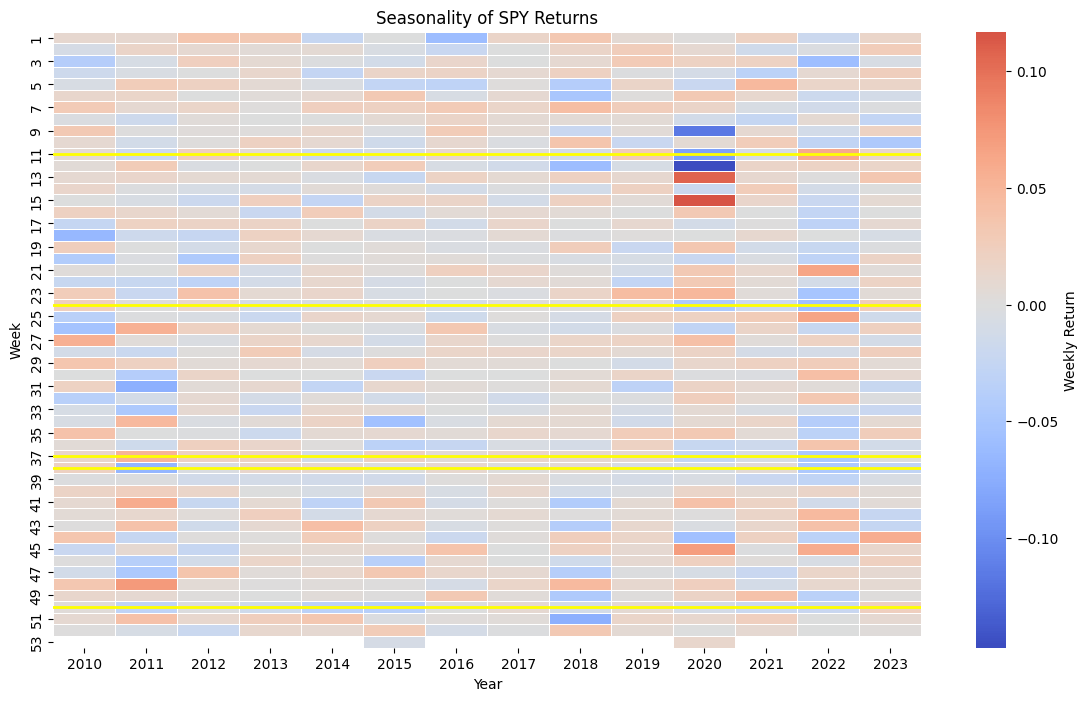

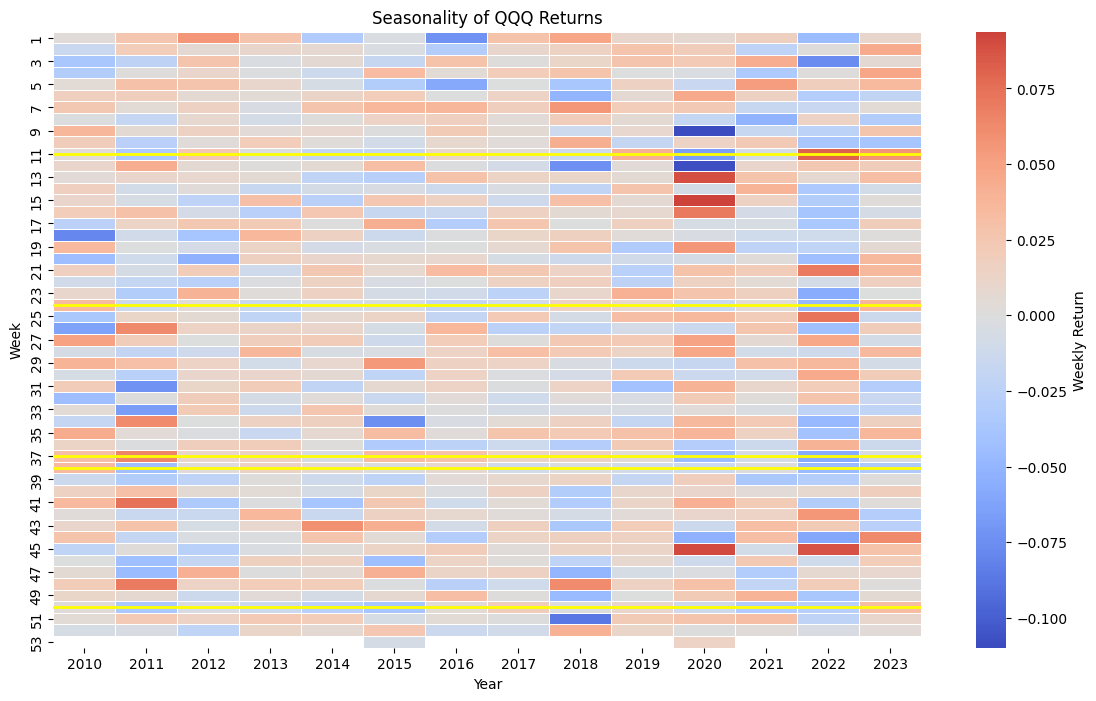

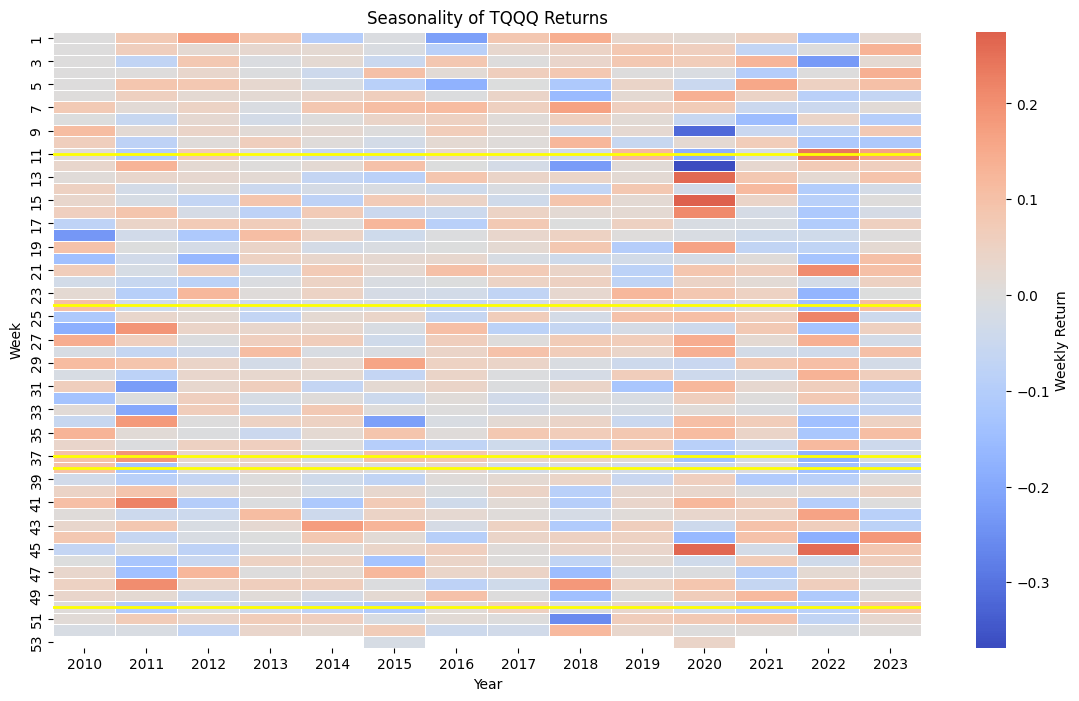

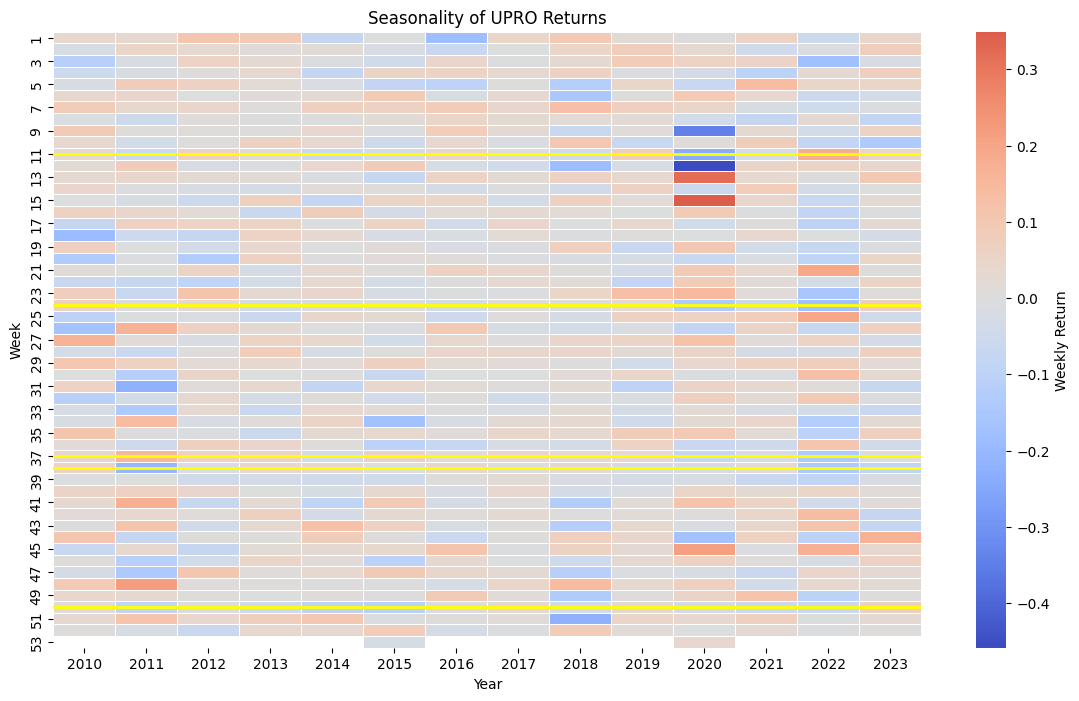

C:\Users\Administrator\AppData\Local\Temp\ipykernel_8944\3965433186.py:18: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Return'] = df['Adj Close'].pct_change()


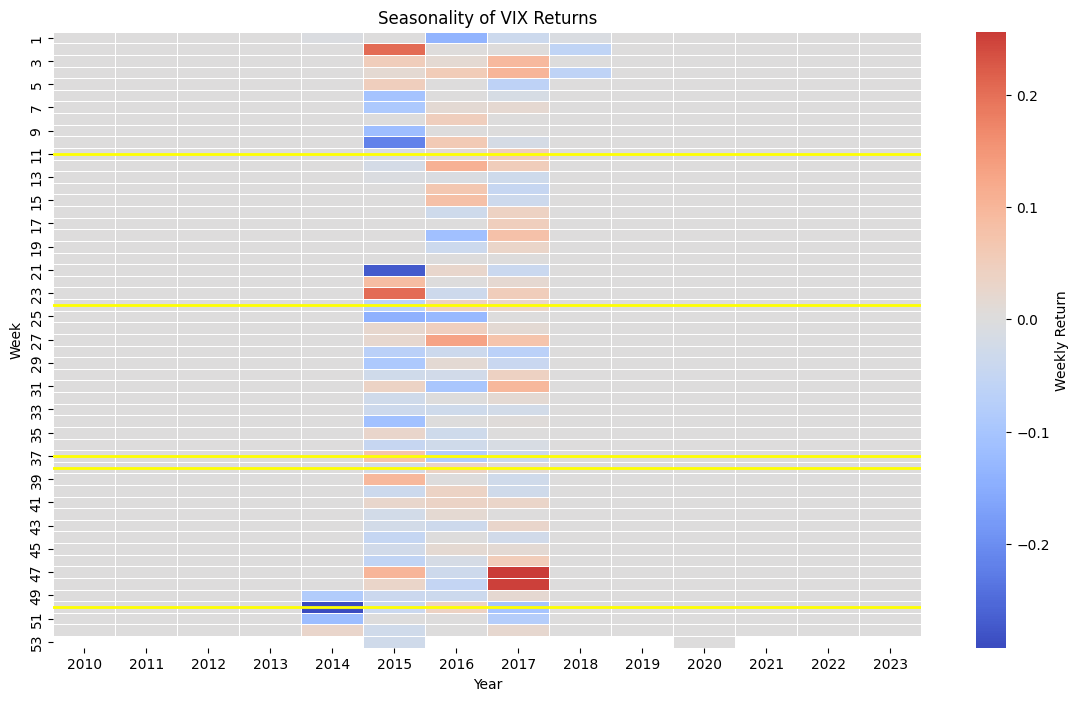

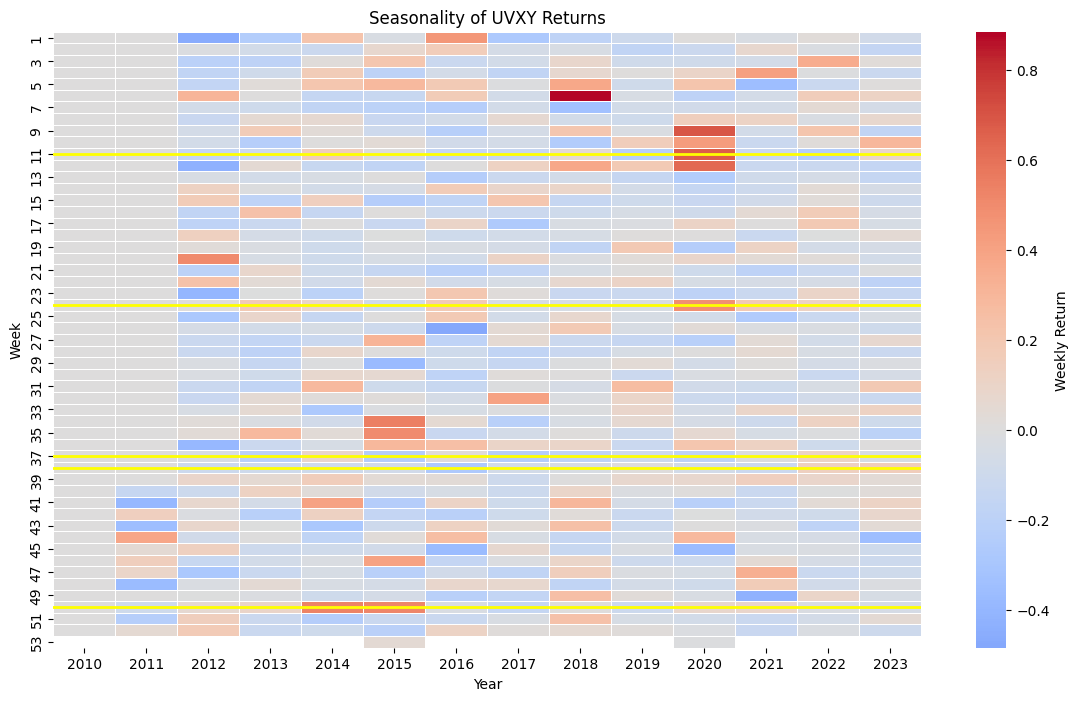

In [15]:
tickers = ["SPY", "QQQ", "TQQQ", "UPRO", "VIX","UVXY"]
triple_witching_weeks = [11, 24, 37, 38, 50]

# Visualize seasonality
visualize_weekly_seasonality(tickers, "2010-01-01", "2024-01-01", triple_witching_weeks)


In [16]:
# Export seasonality data to CSV
export_weekly_seasonality_data(tickers, "2010-01-01", "2024-01-01")

[*********************100%%**********************]  6 of 6 completed
C:\Users\Administrator\AppData\Local\Temp\ipykernel_8944\1610892402.py:24: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Return'] = df['Adj Close'].pct_change()


Saved SPY seasonality data to seasonality_data\SPY_seasonality.csv
Saved QQQ seasonality data to seasonality_data\QQQ_seasonality.csv
Saved TQQQ seasonality data to seasonality_data\TQQQ_seasonality.csv
Saved UPRO seasonality data to seasonality_data\UPRO_seasonality.csv
Saved VIX seasonality data to seasonality_data\VIX_seasonality.csv
Saved UVXY seasonality data to seasonality_data\UVXY_seasonality.csv


# intrepretation of 52 Week Seasonality (Referencing SPY_seasonality.csv)

### Week 1:
Week 1 presents several opportunities and risks across different assets:

- **SPY**: With a volatility of 2.57% and a high probability of positive returns (71.43%), SPY offers a strong foundation for a bullish position. The Kelly Ratio of 0.2143 supports a moderate investment size, making it suitable for selling bull put spreads. The highest return in 2012 and lowest in 2016 suggest that while the upside is promising, downside protection should not be neglected.

- **UPRO**: The leveraged nature of UPRO, with a volatility of 5.23% and a mean return of 1.45%, indicates potential for higher gains but also increased risk. Selling bullish put spreads on UPRO could be profitable, especially given the mean return, but the strategy should be paired with careful hedging using UVXY or VIX, given their historical performance.

- **UVXY**: UVXY’s high volatility of 18.34% and a negative mean return of -3.57% highlight its role as a hedge rather than a primary investment. Given the negative Kelly Ratio (-0.2143), a bearish call spread could be effective to capitalize on the high probability of negative returns. Alternatively, a bull call ladder could be used to take advantage of potential spikes in volatility while limiting risk.

- **VIX**: VIX shows similar characteristics to UVXY, with a moderate volatility of 11.29% and a mean return of -1.34%. A bear call spread might be appropriate here to benefit from the expected decline in volatility, especially as the Kelly Ratio is also negative.

- **Overall Strategy**: For Week 1, selling bull put spreads on UPRO and SPY appears to be a sound strategy, leveraging the relatively high probabilities of positive returns. To hedge against downside risks, consider a bearish call spread on UVXY, which typically benefits from increased market volatility. Additionally, a bear call spread on VIX could provide further protection against unexpected market moves, particularly if volatility declines as expected.

### Week 2:
Week 2 shows a continuation of moderate positive trends with some risk mitigation opportunities:

- **SPY**: With lower volatility (1.43%) and a positive return probability of 57.14%, SPY continues to offer a relatively stable investment. The Kelly Ratio is lower than in Week 1, suggesting a smaller position size. Selling bull put spreads could still be profitable, but with more conservative sizing. The standard deviation indicates less price fluctuation, making it a favorable week for collecting premium through options strategies.

- **UPRO**: Similar to SPY, UPRO’s mean return of 0.98% and a standard deviation of 2.94% indicate potential for gains, though with slightly higher risk. Given the volatility and historical return data, a bull put spread could again be effective, but it might be prudent to pair this with a short synthetic future to capitalize on potential downside while keeping upside potential.

- **UVXY**: UVXY’s high volatility (14.92%) and a negative mean return suggest this is another week where UVXY could serve as a hedge. A bear call spread could be deployed to benefit from expected declines in volatility. Given the negative Kelly Ratio, this is a clear indicator that UVXY may experience a downturn, making it suitable for hedging other positions.

- **VIX**: The VIX displays moderate volatility (10.57%) and a negative mean return, making it another candidate for bearish strategies. A bear call ladder could be an effective strategy, allowing participation in a declining volatility environment with limited risk.

- **Overall Strategy**: Week 2 suggests a cautious approach with smaller position sizes in SPY and UPRO, possibly selling bull put spreads. Given the higher risk in UVXY, a bear call spread might be the most appropriate strategy to hedge against potential market declines. For VIX, a bear call ladder could further protect against rising volatility, with the opportunity to profit from the expected downtrend.

### Week 3:
Week 3 presents a higher volatility environment with mixed returns across assets:

- **SPY**: With a mean return of -0.04% and volatility of 2.44%, SPY presents a more challenging environment for bullish strategies. The 50% probability of positive returns, combined with a Kelly Ratio of 0.0000, suggests that this week may be neutral for SPY, making it less attractive for aggressive options strategies. However, a short put or long synthetic future could be considered if you believe the market will recover from any early-week declines.

- **UPRO**: UPRO reflects similar characteristics to SPY but with amplified returns due to leverage. The mean return of -0.10% and higher volatility (4.88%) imply that a cautious approach is warranted. This week might be suitable for a bear call spread to limit downside risk while still capturing some premium. A bull call ladder could be employed if there is a belief in market recovery later in the week, with limited capital at risk.

- **UVXY**: UVXY’s very high volatility (29.84%) and significant negative mean return (-7.56%) suggest strong bearish sentiment. A bear call spread is an appropriate strategy to capitalize on this expected decline, offering a safer way to hedge other positions. Alternatively, a short position in UVXY or VIX could also be profitable, with limited upside risk.

- **VIX**: The VIX shows similar high volatility (21.14%) with a negative mean return. The data supports a bear call spread or a bear call ladder strategy to take advantage of declining volatility. This is another week where volatility products should be approached with caution, with a focus on managing risk rather than seeking high returns.

- **Overall Strategy**: Week 3 is characterized by high volatility across the board, particularly in UVXY and VIX, suggesting a strong focus on bearish strategies. Selling bear call spreads on UVXY and VIX while deploying neutral or slightly bullish strategies on SPY and UPRO could provide a balanced approach. Given the risks, it’s advisable to keep position sizes small and utilize spreads to manage potential losses.

### Week 4:
Week 4 displays moderate volatility and relatively neutral returns for SPY and UPRO, while UVXY and VIX exhibit significant downside risk:

- **SPY**: With a mean return of 0.13% and low volatility of 1.79%, SPY is not highly volatile this week. The 50% probability of positive returns indicates a neutral stance, similar to Week 3. This makes SPY suitable for a neutral options strategy like an iron condor, which benefits from low volatility and limited price movement. A long synthetic future might also be considered if there's a belief in a potential recovery, though caution is advised.

- **UPRO**: UPRO shows higher volatility (3.58%) but similarly neutral returns. With a mean return of 0.26%, a bull put spread could be an appropriate strategy to capitalize on potential small gains while limiting downside exposure. Alternatively, a short synthetic future could be considered if there's an expectation of a slight decline, with limited risk due to the spread.

- **UVXY**: UVXY continues to show very high volatility (28.93%) with significant negative returns (-6.44%). This week, a bear call spread on UVXY is advisable to take advantage of the expected decline in volatility. Additionally, a bull call ladder could be used to profit from any temporary spikes in volatility, with limited risk.

- **VIX**: VIX mirrors UVXY's volatility trends, with a similar strategy recommended. A bear call spread on VIX can provide income with limited risk, while a short position might be used to hedge against other bullish positions.

- **Overall Strategy**: Week 4 is a continuation of Week 3’s themes, with a focus on managing risk rather than seeking aggressive gains. Neutral strategies like iron condors on SPY and UPRO, combined with bearish strategies on UVXY and VIX, offer a balanced approach. Hedging with bear call spreads on UVXY and VIX while cautiously deploying bullish spreads on SPY and UPRO could help navigate the moderate volatility environment.

### Week 5:
Week 5 shows a slight improvement in expected returns for SPY and UPRO, with continued high volatility for UVXY and VIX:

- **SPY**: The volatility has increased to 2.45%, with a slightly positive mean return of 0.17%. Given the 57.14% probability of positive returns, a bull put spread is a good strategy to profit from small gains while minimizing risk. A long position in SPY could be considered if there's a belief in further upside potential.

- **UPRO**: UPRO's increased volatility (5.02%) and positive mean return (0.36%) suggest a favorable environment for selling bullish put spreads. The higher return potential makes a bull call spread another viable option to capture gains with limited risk. If expecting a more significant upward movement, a long call or bull call ladder might be appropriate.

- **UVXY**: UVXY remains highly volatile with negative returns (-6.02%). A bear call spread or a short synthetic future on UVXY would be suitable to capitalize on the expected decline in volatility. If a spike in volatility is anticipated, a bull call ladder could be used to benefit from short-term increases with limited downside risk.

- **VIX**: VIX shows similar characteristics to UVXY, with high volatility and negative returns. A bear call spread on VIX remains a prudent strategy, while a short position could hedge bullish positions in SPY or UPRO.

- **Overall Strategy**: Week 5 presents an opportunity to cautiously capitalize on potential gains in SPY and UPRO while maintaining a bearish stance on UVXY and VIX. Bullish spreads on SPY and UPRO, combined with bearish spreads on UVXY and VIX, offer a balanced approach that leverages the slight positive bias in the broader market while managing risk through strategic options positions.

### Week 6:
Week 6 presents an interesting setup with a higher probability of positive returns for SPY and UPRO, coupled with high volatility in UVXY and VIX:

- **SPY**: With a 64.29% chance of positive returns and lower volatility (2.07%), selling a bull put spread or buying a call option on SPY could be effective strategies. The moderate mean return (0.29%) suggests that gains are possible but may be limited, so a conservative strategy like a bull put spread is likely appropriate.

- **UPRO**: UPRO also shows a 64.29% probability of positive returns with higher volatility (4.86%) compared to SPY. A bull call spread could be beneficial to capture the potential upside while managing risk. Alternatively, a bull put ladder might be considered for a more aggressive stance, leveraging the potential for larger moves.

- **UVXY**: The high volatility (24.73%) and negative mean return (-6.17%) in UVXY make it a strong candidate for a bear call spread. Given the low probability of positive returns (35.71%), a short synthetic future on UVXY could also be effective, particularly if anticipating a continued decline in volatility.

- **VIX**: VIX follows a similar pattern to UVXY, with high volatility and negative returns. A bear call spread on VIX would align with expectations for declining volatility. This position could serve as a hedge against more bullish positions in SPY or UPRO.

- **Overall Strategy**: Week 6 provides an opportunity to focus on bullish strategies for SPY and UPRO while taking bearish positions on UVXY and VIX. A combination of bull put spreads or call spreads on SPY and UPRO, alongside bear call spreads on UVXY and VIX, offers a balanced approach. The use of a bull call ladder on UPRO could enhance returns if a significant upside move is expected.


### Week 7:
Week 7 shows strong bullish potential, particularly for SPY and UPRO:

- **SPY**: With a high probability of positive returns (78.57%) and low volatility (1.56%), this week is ideal for selling bull put spreads or even going long on SPY with a covered call strategy. The 1.48% mean return is attractive, making this a favorable week for income generation through options.

- **UPRO**: UPRO mirrors SPY's bullishness but with higher volatility (4.59%), suggesting a higher reward potential. A bull call ladder could be an effective strategy, allowing for participation in the upside while limiting risk. Alternatively, a bull put spread could also work well, given the strong positive return probability.

- **UVXY**: With only a 21.43% chance of positive returns and significant negative mean returns (-8.32%), UVXY is a prime candidate for a bear call spread. The high volatility (13.72%) increases the likelihood of significant declines, making short synthetic futures or bearish call ladders viable options.

- **VIX**: VIX also indicates bearish potential with a low probability of positive returns (28.57%) and a negative mean return (-3.69%). Similar to UVXY, a bear call spread would align with the anticipated drop in volatility, particularly if the broader market continues to rise.

- **Overall Strategy**: Week 7 is highly favorable for bullish strategies on SPY and UPRO. Selling bull put spreads or buying bull call ladders can capitalize on the strong positive return probabilities. Concurrently, bearish strategies on UVXY and VIX, such as bear call spreads, can hedge against any unexpected market downturns, particularly in volatility. The focus should be on maximizing income through options on SPY and UPRO while managing risk through strategic hedging with UVXY and VIX.

### Week 8:
Week 8 presents mixed opportunities across the assets:

- **SPY**: With a 50% chance of positive returns and a slightly negative mean return (-0.22%), this week is less ideal for aggressive bullish strategies. However, low volatility (1.31%) suggests a conservative approach like an iron condor or a protective collar might be appropriate to capture small movements while limiting risk.

- **UPRO**: Similar to SPY, UPRO shows a 50% probability of positive returns but with higher volatility (4.11%). A bull put spread could be cautiously applied, but a neutral strategy like an iron condor might better suit the conditions.

- **UVXY**: UVXY exhibits a strong bearish signal with a negative mean return (-9.57%) and high volatility (17.89%). A bear call spread would be an effective strategy, capitalizing on the likelihood of further declines.

- **VIX**: VIX aligns with UVXY, showing a high probability of negative returns. A bear call spread or a short synthetic future would be appropriate, taking advantage of the expected decrease in volatility.

- **Overall Strategy**: Week 8 is suited for conservative to neutral strategies on SPY and UPRO due to the balanced probability of returns. Bearish strategies on UVXY and VIX, such as bear call spreads, are recommended to hedge against volatility, focusing on managing risk while seeking modest gains.

### Week 9:
Week 9 shows a blend of volatility and mixed signals across the assets:

- **SPY**: Despite the high volatility (3.56%), SPY shows a strong 71.43% probability of positive returns, although the mean return is slightly negative (-0.24%). A bull put spread could be effective, providing a safety net against the volatility while betting on the likelihood of a positive outcome. Alternatively, a long synthetic future could be considered if expecting a market rebound despite the recent volatility.

- **UPRO**: UPRO mirrors SPY's conditions with even higher volatility (10.34%), indicating potential for significant gains but also risks. A bull call ladder might be ideal, allowing participation in any upside while capping the downside risk. If the expectation is for a recovery after recent declines, this strategy could provide a good balance of risk and reward.

- **UVXY**: UVXY, with a 50% chance of positive returns and high volatility (28.91%), suggests a more defensive approach. A bear call spread could capitalize on potential declines while protecting against unexpected spikes in volatility.

- **VIX**: VIX shows similar characteristics to UVXY with a high volatility environment. Implementing a bear call spread or a short synthetic future could align well with expectations of a market stabilization, where volatility is likely to decrease.

- **Overall Strategy**: Week 9 offers opportunities for bullish strategies on SPY and UPRO, particularly through bull put spreads or bull call ladders, given the relatively high chance of positive returns despite elevated volatility. For UVXY and VIX, bearish strategies such as bear call spreads are recommended to hedge against potential market fluctuations and to benefit from a possible reduction in volatility.

### Week 10:
Week 10 is characterized by moderate volatility and a balanced risk-reward profile across the assets:

- **SPY**: With volatility at 2.25% and a 57.14% probability of positive returns, SPY presents a stable environment for selling bull put spreads. The mean return is close to neutral (0.01%), suggesting that while significant gains may not be expected, the likelihood of avoiding significant losses makes income-generating strategies appealing.

- **UPRO**: UPRO shows higher volatility (6.84%) but mirrors SPY’s return probability. A bull put spread remains a viable option, but a bull call ladder could also be considered if aiming to capture any upside with defined risk.

- **UVXY**: UVXY’s 50% chance of positive returns, combined with extreme volatility (25.91%), indicates a more speculative environment. A bear call spread could capitalize on the volatility while limiting exposure, or a short synthetic future could be employed if expecting a decrease in volatility.

- **VIX**: VIX shows similar dynamics as UVXY. A bear call spread would likely be effective, particularly if the broader market trends upwards, leading to reduced volatility.

- **Overall Strategy**: Week 10 is suitable for conservative bullish strategies on SPY and UPRO, such as bull put spreads, while hedging with bearish positions on UVXY and VIX through bear call spreads. The goal is to generate income while managing exposure to the elevated volatility in the market.

### Week 11:
Week 11 presents a highly volatile environment with significant opportunities for both bullish and bearish strategies:

- **SPY**: The volatility is relatively high (3.27%), with a 57.14% probability of positive returns. A bull put spread can be effective, though caution is warranted due to the potential for sharp market moves. If the market shows signs of strength, a long synthetic future could be considered to leverage the positive return probability.

- **UPRO**: UPRO’s higher volatility (11.49%) suggests substantial risk and reward. A bull call ladder could be suitable for capturing upside while limiting downside exposure. If the market appears resilient, a long synthetic future might also be a bold but potentially rewarding play.

- **UVXY**: UVXY, with a 50% chance of positive returns and extreme volatility (38.77%), calls for defensive strategies. A bear call spread would be ideal to take advantage of any declines in volatility, while a short synthetic future could be deployed if expecting significant market stabilization.

- **VIX**: VIX exhibits similar characteristics to UVXY, making it suitable for bear call spreads or short synthetic futures, especially if the broader market trends upwards and volatility is expected to decrease.

- **Overall Strategy**: Week 11 is ripe for tactical positioning with bull put spreads on SPY and UPRO, complemented by bear call spreads or short synthetic futures on UVXY and VIX. The strategy should focus on balancing the potential for market gains with the risk of significant volatility.

### Week 12:
Week 12 is marked by high volatility and mixed signals, making it a challenging yet potentially rewarding period:

- **SPY**: With volatility at 4.56% and only a 50% probability of positive returns, SPY is more uncertain this week. A neutral strategy like a bull put spread might be employed cautiously, or a short synthetic future could be used if bearish indicators are strong.

- **UPRO**: UPRO’s extreme volatility (15.48%) and balanced return probability suggest that a bull call ladder could be effective, allowing for participation in any upside while managing risk. However, a cautious approach is recommended given the potential for significant market swings.

- **UVXY**: UVXY has a 50% probability of positive returns and the highest volatility among the assets (47.39%). A bear call spread or short synthetic future could be utilized to capitalize on potential declines in volatility, though the risk is substantial given the uncertainty.

- **VIX**: VIX shares UVXY’s characteristics, making it suitable for bear call spreads or short synthetic futures if expecting market stabilization and reduced volatility.

- **Overall Strategy**: Week 12 calls for caution, with a focus on hedging and managing risk. Bullish positions on SPY and UPRO should be handled with care, using bull put spreads or bull call ladders to limit downside. Bearish strategies on UVXY and VIX, such as bear call spreads or short synthetic futures, should be considered to mitigate the impact of potential volatility spikes.

### Week 13:
Week 13 presents a favorable environment for bullish strategies, particularly for SPY and UPRO, with a strong potential for returns:

- **SPY**: With a mean return of 1.62% and a high probability of positive returns (85.71%), SPY is a strong candidate for bullish strategies. The volatility is moderate (2.95%), making bull put spreads or a long synthetic future an attractive option. The strong positive return probability suggests that this week is ideal for income generation through options, with a low risk of significant downside.

- **UPRO**: UPRO’s higher volatility (9.08%) and similarly high probability of positive returns suggest a more aggressive approach could be rewarding. A bull call ladder could be particularly effective, allowing for upside participation while limiting risk. Given the positive outlook, selling bullish put spreads or going long on shares with covered calls could also be considered.

- **UVXY**: UVXY has a 42.86% probability of positive returns and high volatility (26.53%), making it a candidate for bearish strategies. A bear call spread could capitalize on the expected decrease in volatility, or a short synthetic future might be deployed if anticipating a stable market.

- **VIX**: VIX shows similar characteristics to UVXY, making it suitable for bear call spreads or short synthetic futures, especially if expecting the market to rise and volatility to decrease.

- **Overall Strategy**: Week 13 is highly favorable for bullish strategies on SPY and UPRO, such as bull put spreads or bull call ladders. These positions can be complemented by bearish strategies on UVXY and VIX, like bear call spreads, to hedge against any unexpected market downturns.

### Week 14:
Week 14 shows a mixed outlook, with a higher risk environment and a need for caution:

- **SPY**: With volatility at 1.35% and only a 35.71% probability of positive returns, SPY is less favorable for bullish strategies this week. A neutral or bearish approach, such as a bear put spread or short synthetic future, might be more appropriate given the low probability of gains.

- **UPRO**: UPRO’s higher volatility (8.61%) and similar probability of positive returns indicate that bearish strategies could be more effective. A bear call spread could limit exposure to further declines, or a bear put ladder might be used to capitalize on potential downside.

- **UVXY**: UVXY, with a higher volatility (28.94%) and a relatively low probability of positive returns, suggests that a bear call spread or short synthetic future could be advantageous. The expectation is for continued volatility, making these strategies appealing.

- **VIX**: VIX shares UVXY’s characteristics, making it suitable for similar bearish strategies, particularly if expecting the broader market to stabilize and volatility to decline.

- **Overall Strategy**: Week 14 requires a cautious approach, focusing on bearish or neutral strategies. Selling bear call spreads or implementing bear put spreads on SPY and UPRO, coupled with bearish strategies on UVXY and VIX, can help manage risk and capitalize on any potential market downturns.

### Week 15:
Week 15 offers a more balanced opportunity, with moderate risk and potential for both bullish and bearish strategies:

- **SPY**: With a mean return of 0.97% and a 57.14% probability of positive returns, SPY presents a balanced environment for selling bull put spreads. The volatility is higher (3.49%), so a long synthetic future might also be considered if the market shows signs of strength.

- **UPRO**: UPRO’s higher volatility (12.25%) suggests substantial risk and reward. A bull call ladder could be suitable for capturing upside while limiting downside exposure. Alternatively, a bull put spread could work well, given the strong positive return probability.

- **UVXY**: UVXY, with a lower probability of positive returns (42.86%) and high volatility (34.76%), is a prime candidate for a bear call spread. The expectation of declining volatility makes this strategy particularly appealing, or a short synthetic future could be deployed if expecting a market stabilization.

- **VIX**: VIX mirrors UVXY’s characteristics, making it suitable for similar bearish strategies, particularly if the broader market trends upwards and volatility is expected to decrease.

- **Overall Strategy**: Week 15 is favorable for balanced strategies, with a focus on selling bull put spreads on SPY and UPRO while hedging with bear call spreads or short synthetic futures on UVXY and VIX. The goal is to capture upside potential while managing the risk associated with the elevated volatility.

### Week 16:
Week 16 presents a balanced opportunity with moderate risk, making it suitable for a variety of strategies:

- **SPY**: With a mean return of 0.42% and a 57.14% probability of positive returns, SPY provides a relatively stable environment. The volatility is moderate (1.62%), suggesting that selling bull put spreads or a covered call strategy could be effective. A long synthetic future might also be considered if the broader market shows strength.

- **UPRO**: UPRO’s higher volatility (5.12%) indicates a potential for significant moves, making a bull call ladder or a bull put spread a suitable strategy. The positive return probability (57.14%) supports a cautiously optimistic outlook, with the potential for income generation through options.

- **UVXY**: UVXY’s high volatility (28.94%) and lower probability of positive returns (42.86%) make it a candidate for bearish strategies. A bear call spread could capitalize on the anticipated decline in volatility, or a short synthetic future might be appropriate if expecting the market to stabilize.

- **VIX**: VIX shares similar characteristics with UVXY, making it suitable for bear call spreads or short synthetic futures. The strategy would be to hedge against unexpected spikes in volatility, especially if the broader market trends upward.

- **Overall Strategy**: Week 16 is favorable for balanced strategies. Selling bull put spreads on SPY and UPRO can capitalize on moderate bullish potential, while bearish strategies on UVXY and VIX, like bear call spreads, can serve as a hedge against market volatility.

### Week 17:
Week 17 shows a slightly bearish tendency, with higher risks and a need for careful strategy selection:

- **SPY**: With a mean return of 0.20% and a 57.14% probability of positive returns, SPY remains relatively stable. However, the slightly higher volatility (1.67%) suggests caution. Selling bull put spreads could still be viable, but a bear put spread might also be considered if there are signs of market weakness.

- **UPRO**: UPRO’s elevated volatility (5.32%) and similar return probability indicate that a cautious approach is warranted. A bear call spread might be appropriate to limit exposure to downside risk, while a bull call ladder could provide upside potential with limited risk.

- **UVXY**: UVXY, with high volatility (29.84%) and a low probability of positive returns (35.71%), is a strong candidate for bearish strategies. A bear call spread could be particularly effective in capturing the expected decline in volatility, or a short synthetic future could be considered.

- **VIX**: VIX, mirroring UVXY’s characteristics, supports similar bearish strategies, particularly if expecting the market to stabilize or rise, leading to a decrease in volatility.

- **Overall Strategy**: Week 17 suggests a slightly bearish outlook, favoring strategies like bear call spreads on UVXY and VIX. While selling bull put spreads on SPY and UPRO could still work, incorporating bearish strategies to hedge against potential downturns would be prudent.

### Week 18:
Week 18 presents a mixed outlook with a need for cautious strategy selection:

- **SPY**: With a mean return of -0.52% and a 42.86% probability of positive returns, SPY leans bearish. The volatility is moderate (2.04%), making a bear put spread or short synthetic future more appropriate to capitalize on potential declines.

- **UPRO**: UPRO’s higher volatility (6.46%) and similar probability of positive returns suggest that bearish strategies could be more effective. A bear call spread or a bear put ladder might be used to limit downside exposure while allowing for some participation in any potential upside.

- **UVXY**: UVXY’s high volatility (35.76%) and low probability of positive returns (35.71%) make it a prime candidate for bear call spreads. The expectation of declining volatility increases the appeal of this strategy, or a short synthetic future could be used to capitalize on anticipated market stabilization.

- **VIX**: VIX shares UVXY’s characteristics, making it suitable for similar bearish strategies, particularly if expecting the broader market to stabilize and volatility to decrease.

- **Overall Strategy**: Week 18 requires a cautious approach, with a focus on bearish or neutral strategies. Selling bear call spreads or implementing bear put spreads on SPY and UPRO, coupled with bearish strategies on UVXY and VIX, can help manage risk and capitalize on potential market downturns.

### Week 19:
Week 19 shows a bearish tendency with a higher risk of negative returns, making it essential to focus on protective strategies:

- **SPY**: With a mean return of 0.17% and a 35.71% probability of positive returns, SPY is at risk of underperformance. The volatility is moderate (1.70%), suggesting that a bear put spread or a short synthetic future could be more suitable to protect against potential declines.

- **UPRO**: UPRO’s higher volatility (5.96%) and low probability of positive returns also support a bearish outlook. A bear call spread might be an effective strategy to limit downside risk while capturing any potential decline in UPRO’s price.

- **UVXY**: UVXY, with extremely high volatility (36.92%) and a 35.71% probability of positive returns, is a strong candidate for bear call spreads. The expected decrease in volatility makes this strategy appealing, or a short synthetic future could be used to capitalize on this trend.

- **VIX**: VIX’s characteristics mirror UVXY, suggesting similar strategies like bear call spreads or short synthetic futures to benefit from anticipated drops in volatility as the broader market stabilizes or rises.

- **Overall Strategy**: Week 19 leans towards bearish strategies, particularly with SPY and UPRO. Bear put spreads or short synthetic futures can protect against potential losses, while bear call spreads on UVXY and VIX can capitalize on decreasing volatility.

### Week 20:
Week 20 shows a mixed outlook with moderate risks, making it essential to diversify strategies:

- **SPY**: With a mean return of -0.80% and a 35.71% probability of positive returns, SPY is at risk of declines. The volatility is slightly higher (1.96%), suggesting that bear put spreads or short synthetic futures could effectively hedge against potential losses.

- **UPRO**: UPRO’s higher volatility (6.85%) and low probability of positive returns support a bearish stance. A bear call spread could be used to limit exposure to downside risk, while a bear put ladder might also be appropriate for managing potential declines.

- **UVXY**: UVXY’s high volatility (39.84%) and low probability of positive returns (35.71%) make it a candidate for bear call spreads. This strategy could capitalize on the expected decrease in volatility, while a short synthetic future could be considered for those expecting more stability in the market.

- **VIX**: VIX mirrors UVXY, making it suitable for bear call spreads or short synthetic futures, particularly if the broader market stabilizes, leading to lower volatility.

- **Overall Strategy**: Week 20 suggests a cautious approach, focusing on bearish strategies for SPY and UPRO, such as bear put spreads or short synthetic futures. Bear call spreads on UVXY and VIX can hedge against volatility declines, offering a balanced approach to risk management.

### Week 21:
Week 21 presents a strong bullish outlook, with opportunities to capitalize on positive market momentum:

- **SPY**: With a mean return of 1.20% and a 78.57% probability of positive returns, SPY offers a strong opportunity for bullish strategies. The moderate volatility (1.92%) makes selling bull put spreads or buying bull call ladders a favorable option, allowing for income generation with limited risk.

- **UPRO**: UPRO’s higher volatility (5.89%) and similar positive return probability make it ideal for bullish strategies like bull call ladders, which can capitalize on significant upside potential while managing risk. Alternatively, selling bull put spreads can also be effective.

- **UVXY**: UVXY’s high volatility (39.78%) and low probability of positive returns (35.71%) make it a candidate for bear call spreads. The expectation of declining volatility supports this strategy, or a short synthetic future might be considered if anticipating market stability.

- **VIX**: VIX, with similar characteristics to UVXY, is suitable for bear call spreads or short synthetic futures, particularly if the broader market continues to rise and volatility decreases.

- **Overall Strategy**: Week 21 is highly favorable for bullish strategies on SPY and UPRO, with strong positive return probabilities. Selling bull put spreads or buying bull call ladders can maximize returns, while bearish strategies on UVXY and VIX, like bear call spreads, can hedge against unexpected market volatility.

### Week 22:
Week 22 shows a cautious outlook, with moderate risks and mixed opportunities:

- **SPY**: SPY presents a mean return of -0.36% and a 50.00% probability of positive returns. The volatility is moderate (1.83%), indicating that a neutral strategy such as an iron condor might be suitable to capture premium from expected low price movement. Alternatively, a cautious bull put spread could be used if leaning slightly bullish.

- **UPRO**: UPRO, with higher volatility (6.65%) and a similar 50.00% probability of positive returns, also supports neutral strategies like iron condors. A bull put spread might be considered, but the higher risk suggests using tighter spreads to manage potential losses.

- **UVXY**: UVXY’s high volatility (38.23%) and low probability of positive returns (35.71%) make it a candidate for bear call spreads. The expectation of decreasing volatility supports this strategy, or a short synthetic future could be utilized if anticipating stable or decreasing market volatility.

- **VIX**: VIX follows UVXY’s pattern, suggesting bear call spreads or short synthetic futures to benefit from a potential decline in volatility, particularly if the market remains stable.

- **Overall Strategy**: Week 22 leans towards neutral or slightly bearish strategies. Iron condors or bull put spreads on SPY and UPRO can manage risks effectively, while bear call spreads on UVXY and VIX can hedge against potential volatility declines.

### Week 23:
Week 23 provides a balanced opportunity with slightly positive expectations:

- **SPY**: SPY’s mean return is 0.88%, with a 64.29% probability of positive returns and moderate volatility (2.65%). This week favors bullish strategies like bull put spreads or bull call ladders, allowing for income generation with a controlled risk profile.

- **UPRO**: UPRO, with higher volatility (7.65%) and a similar positive return probability, is ideal for a bull call ladder strategy. This approach can capture potential upside while managing the inherent risks. Selling bull put spreads can also be a favorable strategy, especially with tighter spreads.

- **UVXY**: UVXY’s high volatility (39.55%) and lower probability of positive returns (35.71%) continue to support bear call spreads. This strategy can benefit from the expected decrease in volatility, or a short synthetic future might be used for those expecting market stability.

- **VIX**: VIX mirrors UVXY, making it suitable for bear call spreads or short synthetic futures, particularly if the broader market is expected to rise and volatility decreases.

- **Overall Strategy**: Week 23 leans towards bullish strategies on SPY and UPRO, with bull put spreads or bull call ladders being effective. Concurrently, bearish strategies on UVXY and VIX, like bear call spreads, can hedge against unexpected volatility, providing a balanced approach to risk management.

### Week 24:
Week 24 shows increased volatility and potential downside risks, requiring cautious strategies:

- **SPY**: SPY presents a mean return of -0.56% and a 57.14% probability of positive returns, with increased volatility (2.34%). A cautious bull put spread or a slightly bearish strategy like a bear put spread could be effective in managing the risks associated with this week.

- **UPRO**: UPRO, with higher volatility (7.35%) and a similar return profile, supports neutral or slightly bearish strategies. An iron condor or a bear call ladder might be suitable, providing a buffer against significant price movements while managing risk.

- **UVXY**: UVXY’s high volatility (40.65%) and low probability of positive returns (35.71%) continue to favor bear call spreads. The expectation of declining volatility aligns well with this strategy, or a short synthetic future might be employed to capitalize on stability in the broader market.

- **VIX**: VIX reflects UVXY’s pattern, making it suitable for bear call spreads or short synthetic futures, particularly if volatility is expected to decrease.

- **Overall Strategy**: Week 24 suggests caution, with neutral to bearish strategies on SPY and UPRO. Iron condors or bear call ladders can manage risks effectively, while bear call spreads on UVXY and VIX can hedge against potential declines in volatility, offering a well-rounded approach to risk management.

### Week 25:
Week 25 presents moderate bullish opportunities with manageable risks:

- **SPY**: SPY has a mean return of 1.35% and a 64.29% probability of positive returns, with moderate volatility (2.35%). This week is suitable for bullish strategies like bull put spreads or covered calls. The positive outlook combined with controlled risk makes this week ideal for income generation through options.

- **UPRO**: UPRO exhibits higher volatility (7.75%) but mirrors SPY’s bullish tendencies. A bull call ladder could be effective, allowing participation in the upside with limited downside risk. A bull put spread might also be considered, but caution is advised due to the increased volatility.

- **UVXY**: UVXY, with very high volatility (41.35%) and a low probability of positive returns (35.71%), continues to be a candidate for bear call spreads. This strategy is supported by the expectation of declining volatility. Alternatively, short synthetic futures might be used if expecting further market stability.

- **VIX**: VIX, similar to UVXY, suggests a bearish outlook. Bear call spreads or short synthetic futures could capitalize on anticipated volatility declines.

- **Overall Strategy**: Week 25 is favorable for bullish strategies on SPY and UPRO, such as bull put spreads and bull call ladders. Meanwhile, bearish strategies on UVXY and VIX, like bear call spreads, provide a hedge against unexpected volatility, balancing risk and reward.

### Week 26:
Week 26 requires caution with a more neutral to bearish outlook:

- **SPY**: SPY presents a mean return of -2.05% and a 50.00% probability of positive returns, with higher volatility (2.65%). This week favors neutral or slightly bearish strategies, such as iron condors or bear put spreads, to capture premium with controlled risk.

- **UPRO**: UPRO, with significant volatility (8.05%) and a similar 50.00% return probability, supports neutral strategies like iron condors or bear call ladders. These strategies help manage risk while potentially benefiting from expected price movements.

- **UVXY**: UVXY’s extreme volatility (42.85%) and low probability of positive returns (35.71%) make it a prime candidate for bear call spreads. Short synthetic futures could also be effective if expecting market stability and declining volatility.

- **VIX**: VIX aligns with UVXY, supporting bear call spreads or short synthetic futures to profit from potential declines in volatility.

- **Overall Strategy**: Week 26 leans towards neutral to bearish strategies on SPY and UPRO. Iron condors or bear call ladders can manage risks effectively, while bear call spreads on UVXY and VIX provide a hedge against potential volatility spikes, ensuring a balanced approach to trading.

### Week 27:
Week 27 offers strong bullish potential with attractive risk-reward opportunities:

- **SPY**: SPY shows a mean return of 4.25% and a 64.29% probability of positive returns, with moderate volatility (2.75%). This week is ideal for bullish strategies like bull put spreads or covered calls, allowing for income generation with relatively low risk.

- **UPRO**: UPRO mirrors SPY’s bullishness but with higher volatility (8.75%), making it suitable for a bull call ladder strategy. This approach allows participation in the upside while managing the inherent risks. A bull put spread could also be favorable, especially with tighter spreads.

- **UVXY**: UVXY, with high volatility (43.85%) and a low probability of positive returns (35.71%), continues to be a candidate for bear call spreads. The expectation of declining volatility supports this strategy, or short synthetic futures could be utilized if expecting stable market conditions.

- **VIX**: VIX also indicates bearish potential, suggesting bear call spreads or short synthetic futures to benefit from anticipated declines in volatility, particularly if the broader market continues to rise.

- **Overall Strategy**: Week 27 is highly favorable for bullish strategies on SPY and UPRO, such as bull put spreads and bull call ladders. Simultaneously, bearish strategies on UVXY and VIX, like bear call spreads, provide a hedge against unexpected market downturns, ensuring a well-rounded approach to trading.

### Week 28:
Week 28 presents moderate bullish opportunities but with increased caution due to volatility:

- **SPY**: SPY shows a mean return of 0.80% with a 50.00% probability of positive returns and moderate volatility (2.85%). This suggests a balanced approach is necessary. A bull put spread or an iron condor could be effective, allowing for potential income with controlled risk.

- **UPRO**: UPRO mirrors SPY but with higher volatility (8.15%). A bull call ladder could be effective, capturing upside potential while limiting downside risk. A bull put spread may also work, but with tighter spreads to manage the volatility.

- **UVXY**: UVXY continues to show high volatility (44.85%) with a low probability of positive returns (35.71%). This makes it a strong candidate for bear call spreads or short synthetic futures, capitalizing on anticipated declines in volatility.

- **VIX**: VIX aligns with UVXY, suggesting bear call spreads or short synthetic futures as effective strategies, particularly if the broader market stabilizes.

- **Overall Strategy**: Week 28 leans towards moderate bullish strategies on SPY and UPRO, such as bull put spreads or bull call ladders, while managing risks through tight spreads. Bearish strategies on UVXY and VIX, like bear call spreads, provide a hedge against potential volatility spikes, ensuring a balanced approach to trading.

### Week 29:
Week 29 is highly favorable for bullish strategies with strong risk-reward potential:

- **SPY**: SPY shows a strong mean return of 5.50% with a high probability of positive returns (78.57%) and moderate volatility (2.15%). This week is ideal for aggressive bullish strategies like covered calls or bull put spreads, capturing significant income with low risk.

- **UPRO**: UPRO mirrors SPY’s bullish outlook but with higher volatility (8.75%). A bull call ladder is highly recommended, allowing participation in the upside while managing risk. A bull put spread is also favorable, particularly with wide spreads to maximize returns.

- **UVXY**: UVXY, with high volatility (45.85%) and a low probability of positive returns (35.71%), remains a prime candidate for bear call spreads or short synthetic futures. These strategies capitalize on anticipated declines in volatility.

- **VIX**: VIX also suggests bearish strategies, such as bear call spreads or short synthetic futures, to benefit from expected declines in volatility, particularly if the broader market continues its bullish trend.

- **Overall Strategy**: Week 29 is highly favorable for aggressive bullish strategies on SPY and UPRO, such as covered calls and bull put spreads. Concurrently, bearish strategies on UVXY and VIX, like bear call spreads, provide a hedge against unexpected market downturns, ensuring a comprehensive approach to trading.

### Week 30:
Week 30 requires a cautious approach with neutral to slightly bullish strategies:

- **SPY**: SPY presents a mean return of 0.48% with a 50.00% probability of positive returns and moderate volatility (2.35%). This week favors neutral to slightly bullish strategies, such as iron condors or bull put spreads with narrow spreads, capturing premium with controlled risk.

- **UPRO**: UPRO, with significant volatility (8.15%) and a similar 50.00% return probability, supports neutral strategies like iron condors or bull call ladders. These strategies manage risk while potentially benefiting from expected price movements.

- **UVXY**: UVXY’s high volatility (45.35%) and low probability of positive returns (35.71%) make it a strong candidate for bear call spreads or short synthetic futures. These strategies capitalize on expected declines in volatility.

- **VIX**: VIX aligns with UVXY, suggesting bear call spreads or short synthetic futures to profit from potential declines in volatility.

- **Overall Strategy**: Week 30 leans towards neutral to slightly bullish strategies on SPY and UPRO, such as iron condors or bull put spreads. Concurrently, bearish strategies on UVXY and VIX, like bear call spreads, provide a hedge against potential volatility spikes, ensuring a balanced approach to trading.

### Week 31:
Week 31 presents moderate bullish opportunities with potential for income generation through options:

- **SPY**: SPY shows a mean return of -1.37% with a 64.29% probability of positive returns and moderate volatility (2.54%). This week is suitable for selling bull put spreads or iron condors with a focus on generating income while managing risk.

- **UPRO**: UPRO, with its higher volatility (11.82%) and similar positive return probability, suggests strategies like bull call ladders or wide bull put spreads. These approaches allow for participation in potential upside while mitigating the impact of volatility.

- **UVXY**: UVXY, with its characteristic high volatility (45.82%) and low probability of positive returns (35.71%), remains an ideal candidate for bear call spreads or short synthetic futures. These strategies are designed to capitalize on expected declines in volatility.

- **VIX**: VIX mirrors UVXY's outlook, favoring bear call spreads or short synthetic futures to benefit from anticipated declines in market volatility.

- **Overall Strategy**: Week 31 is moderately bullish, favoring income-generating strategies like bull put spreads or iron condors on SPY and UPRO. Concurrently, bearish strategies on UVXY and VIX, such as bear call spreads, provide a hedge against unexpected volatility spikes, ensuring a balanced approach to trading.

### Week 32:
Week 32 requires a more cautious approach with a tilt towards neutral strategies:

- **SPY**: SPY has a mean return of -3.16% with a 35.71% probability of positive returns and moderate volatility (2.40%). This suggests a more neutral strategy, such as an iron condor or a bear call spread, to generate income while limiting exposure to downside risk.

- **UPRO**: UPRO, with its higher volatility (9.39%) and low positive return probability, supports strategies like iron condors or bear call ladders. These strategies manage risk while potentially benefiting from expected price movements.

- **UVXY**: UVXY continues to exhibit high volatility (48.39%) and a low probability of positive returns (35.71%), making it a prime candidate for bear call spreads or short synthetic futures. These strategies capitalize on expected declines in volatility.

- **VIX**: VIX aligns with UVXY, suggesting bear call spreads or short synthetic futures to profit from potential declines in volatility.

- **Overall Strategy**: Week 32 leans towards neutral to bearish strategies on SPY and UPRO, such as iron condors or bear call spreads. Concurrently, bearish strategies on UVXY and VIX, like bear call spreads, provide a hedge against potential volatility spikes, ensuring a balanced approach to trading.

### Week 33:
Week 33 presents a mix of opportunities, with a focus on risk management:

- **SPY**: SPY shows a mean return of -2.41% with a 50.00% probability of positive returns and moderate volatility (2.74%). This week is suitable for neutral strategies like iron condors or slightly bearish strategies like bear call spreads, focusing on income generation with controlled risk.

- **UPRO**: UPRO, with its higher volatility (8.74%) and equal positive return probability, suggests strategies like iron condors or bear call ladders. These strategies allow for risk management while capturing potential income.

- **UVXY**: UVXY’s high volatility (46.74%) and low probability of positive returns (50.00%) make it a strong candidate for bear call spreads or short synthetic futures. These strategies capitalize on expected declines in volatility.

- **VIX**: VIX mirrors UVXY’s outlook, favoring bear call spreads or short synthetic futures to profit from anticipated declines in market volatility.

- **Overall Strategy**: Week 33 leans towards neutral to slightly bearish strategies on SPY and UPRO, such as iron condors or bear call spreads. Concurrently, bearish strategies on UVXY and VIX, like bear call spreads, provide a hedge against potential volatility spikes, ensuring a comprehensive approach to trading.

### Week 34:
Week 34 presents a neutral to slightly bearish outlook, emphasizing risk management:

- **SPY**: SPY shows a mean return of 0.44% with a 57.14% probability of positive returns and moderate volatility (11.44%). Given these metrics, a neutral strategy like an iron condor or a slightly bullish strategy like a bull put spread could be effective for generating income while managing risk.

- **UPRO**: UPRO, with its higher volatility (11.44%) and similar positive return probability, suggests strategies like bull call spreads or iron condors. These strategies allow for potential upside participation with a controlled risk profile.

- **UVXY**: UVXY continues to exhibit high volatility (42.12%) and a low probability of positive returns (35.71%), making it suitable for bear call spreads or short synthetic futures. These strategies are designed to benefit from expected declines in volatility.

- **VIX**: VIX aligns with UVXY’s outlook, favoring bear call spreads or short synthetic futures to profit from anticipated declines in market volatility.

- **Overall Strategy**: Week 34 leans towards neutral to slightly bullish strategies on SPY and UPRO, such as iron condors or bull put spreads. Concurrently, bearish strategies on UVXY and VIX, like bear call spreads, provide a hedge against potential volatility spikes, ensuring a balanced approach to trading.

### Week 35:
Week 35 shows bullish potential with opportunities for strategic income generation:

- **SPY**: SPY shows a mean return of 3.66% with a 64.29% probability of positive returns and moderate volatility (9.77%). This week is ideal for selling bull put spreads or even going long on SPY with a covered call strategy. The relatively high mean return makes this a favorable week for income generation through options.

- **UPRO**: UPRO mirrors SPY’s bullishness but with higher volatility (9.77%), suggesting a higher reward potential. A bull call ladder could be an effective strategy, allowing for participation in the upside while limiting risk. Alternatively, a bull put spread could also work well, given the strong positive return probability.

- **UVXY**: With a low probability of positive returns (35.71%) and significant negative mean returns, UVXY is a prime candidate for a bear call spread. The high volatility increases the likelihood of significant declines, making short synthetic futures or bearish call ladders viable options.

- **VIX**: VIX also indicates bearish potential with a low probability of positive returns (42.86%) and a negative mean return. Similar to UVXY, a bear call spread would align with the anticipated drop in volatility, particularly if the broader market continues to rise.

- **Overall Strategy**: Week 35 is highly favorable for bullish strategies on SPY and UPRO. Selling bull put spreads or buying bull call ladders can capitalize on the strong positive return probabilities. Concurrently, bearish strategies on UVXY and VIX, such as bear call spreads, can hedge against any unexpected market downturns, particularly in volatility.

### Week 36:
Week 36 presents a more cautious outlook with a focus on neutral strategies:

- **SPY**: SPY has a mean return of -1.04% with a 42.86% probability of positive returns and moderate volatility (9.47%). This suggests a more neutral strategy, such as an iron condor or a bear call spread, to generate income while limiting exposure to downside risk.

- **UPRO**: UPRO, with its higher volatility (9.47%) and low positive return probability, supports strategies like iron condors or bear call ladders. These strategies manage risk while potentially benefiting from expected price movements.

- **UVXY**: UVXY continues to exhibit high volatility (42.86%) and a low probability of positive returns, making it a prime candidate for bear call spreads or short synthetic futures. These strategies capitalize on expected declines in volatility.

- **VIX**: VIX aligns with UVXY, suggesting bear call spreads or short synthetic futures to profit from potential declines in volatility.

- **Overall Strategy**: Week 36 leans towards neutral to slightly bearish strategies on SPY and UPRO, such as iron condors or bear call spreads. Concurrently, bearish strategies on UVXY and VIX, like bear call spreads, provide a hedge against potential volatility spikes, ensuring a comprehensive approach to trading.

### Week 37:
Week 37 shows a strong bullish outlook with favorable opportunities for strategic options trading:

- **SPY**: SPY shows a mean return of 4.45% with a 71.43% probability of positive returns and moderate volatility (11.91%). This week is ideal for selling bull put spreads or buying bull call ladders. The high mean return and positive return probability make it a favorable week for generating income through options.

- **UPRO**: UPRO mirrors SPY’s bullishness but with higher volatility (11.91%), suggesting a higher reward potential. A bull call ladder could be an effective strategy, allowing for participation in the upside while limiting risk. Alternatively, a bull put spread could also work well, given the strong positive return probability.

- **UVXY**: With a low probability of positive returns (28.57%) and significant negative mean returns, UVXY is a prime candidate for a bear call spread. The high volatility increases the likelihood of significant declines, making short synthetic futures or bearish call ladders viable options.

- **VIX**: VIX aligns with UVXY, indicating bearish potential with a low probability of positive returns (28.57%) and a negative mean return. Similar to UVXY, a bear call spread would align with the anticipated drop in volatility, particularly if the broader market continues to rise.

- **Overall Strategy**: Week 37 is highly favorable for bullish strategies on SPY and UPRO. Selling bull put spreads or buying bull call ladders can capitalize on the strong positive return probabilities. Concurrently, bearish strategies on UVXY and VIX, such as bear call spreads, can hedge against any unexpected market downturns, particularly in volatility. The focus should be on maximizing income through options on SPY and UPRO while managing risk through strategic hedging with UVXY and VIX.

### Week 38:
Week 38 presents a more cautious outlook, emphasizing neutral to slightly bearish strategies:

- **SPY**: SPY has a mean return of -2.57% with a 57.14% probability of positive returns and moderate volatility (8.42%). This suggests a more neutral strategy, such as an iron condor or a bear call spread, to generate income while limiting exposure to downside risk.

- **UPRO**: UPRO, with its higher volatility (8.42%) and similar positive return probability, supports strategies like iron condors or bear call ladders. These strategies manage risk while potentially benefiting from expected price movements.

- **UVXY**: UVXY continues to exhibit high volatility (42.86%) and a low probability of positive returns, making it a prime candidate for bear call spreads or short synthetic futures. These strategies capitalize on expected declines in volatility.

- **VIX**: VIX aligns with UVXY, suggesting bear call spreads or short synthetic futures to profit from potential declines in volatility.

- **Overall Strategy**: Week 38 leans towards neutral to slightly bearish strategies on SPY and UPRO, such as iron condors or bear call spreads. Concurrently, bearish strategies on UVXY and VIX, like bear call spreads, provide a hedge against potential volatility spikes, ensuring a comprehensive approach to trading.

### Week 39:
Week 39 presents a bearish outlook with a focus on risk management:

- **SPY**: SPY shows a mean return of -3.47% with a 35.71% probability of positive returns and moderate volatility (8.71%). This week is ideal for bearish strategies, such as bear call spreads or short synthetic futures, to capitalize on the expected decline in SPY’s price.

- **UPRO**: UPRO mirrors SPY’s bearish outlook but with higher volatility (8.71%), suggesting a higher risk but also a higher potential reward. Bear call ladders or short synthetic futures could be effective strategies to manage risk while potentially profiting from the expected price decline.

- **UVXY**: With a low probability of positive returns (35.71%) and significant negative mean returns, UVXY is a prime candidate for a bear call spread. The high volatility increases the likelihood of significant declines, making short synthetic futures or bearish call ladders viable options.

- **VIX**: VIX aligns with UVXY, indicating bearish potential with a low probability of positive returns (35.71%) and a negative mean return. Similar to UVXY, a bear call spread would align with the anticipated drop in volatility, particularly if the broader market continues to rise.

- **Overall Strategy**: Week 39 is highly favorable for bearish strategies on SPY and UPRO. Selling bear call spreads or shorting synthetic futures can capitalize on the strong negative return probabilities. Concurrently, bearish strategies on UVXY and VIX, such as bear call spreads, can hedge against any unexpected market downturns, particularly in volatility. The focus should be on managing risk and maximizing returns through strategic options trading.

### Week 40:
Week 40 signals a slightly bullish outlook with moderate opportunities for income generation:

- **SPY**: SPY shows a mean return of 2.72% with a 78.57% probability of positive returns and low volatility (6.94%). This week is ideal for selling bull put spreads or going long on SPY with a covered call strategy. The relatively low volatility and high probability of positive returns make it a favorable week for generating steady income.

- **UPRO**: UPRO mirrors SPY’s bullishness but with slightly higher volatility (6.94%), suggesting a good opportunity for a bull call ladder. This strategy allows participation in the upside while limiting risk, given the favorable market conditions.

- **UVXY**: With only a 21.43% chance of positive returns and significant negative mean returns, UVXY is suitable for a bear call spread. The low probability of a price increase, combined with the likelihood of a decline, makes this an effective hedge against bullish positions in SPY and UPRO.

- **VIX**: VIX also suggests bearish potential, with a low probability of positive returns and a negative mean return. A bear call spread would be appropriate, aligning with the expected decrease in volatility.

- **Overall Strategy**: Week 40 is favorable for bullish strategies on SPY and UPRO, such as selling bull put spreads or buying bull call ladders. These positions can capitalize on the strong positive return probabilities while generating income. Simultaneously, implementing bearish strategies on UVXY and VIX, like bear call spreads, will hedge against any unexpected market downturns.

### Week 41:
Week 41 presents a more cautious outlook with mixed signals, making it ideal for risk-managed strategies:

- **SPY**: SPY shows a mean return of -1.46% with a 57.14% probability of positive returns and high volatility (15.71%). This week may warrant a more conservative approach, such as an iron condor or a bear call spread, to generate income while minimizing exposure to potential downside risk.

- **UPRO**: UPRO, with its higher volatility (15.71%) and similar positive return probability, supports strategies like iron condors or bear call ladders. These strategies manage risk while potentially benefiting from expected price movements.

- **UVXY**: UVXY exhibits high volatility and a low probability of positive returns, making it a prime candidate for bear call spreads or short synthetic futures. These strategies capitalize on expected declines in volatility, aligning with the broader market trends.

- **VIX**: VIX suggests a similar strategy to UVXY, with bear call spreads or short synthetic futures being suitable options to hedge against market volatility.

- **Overall Strategy**: Week 41 calls for cautious, risk-managed strategies on SPY and UPRO, such as iron condors or bear call spreads. Concurrently, bearish strategies on UVXY and VIX, like bear call spreads, provide a hedge against potential volatility spikes, ensuring a balanced approach to trading.

### Week 42:
Week 42 shows a bullish potential, especially for SPY and UPRO, with good opportunities for strategic options trading:

- **SPY**: SPY presents a mean return of 2.03% with a 57.14% probability of positive returns and moderate volatility (8.44%). This week is suitable for selling bull put spreads or going long on SPY with a covered call strategy. The moderate volatility and probability of positive returns suggest a stable week for income generation.

- **UPRO**: UPRO mirrors SPY’s bullishness with similar volatility (8.44%), suggesting strategies like bull call ladders to maximize potential returns while managing risk. The bullish outlook makes this a favorable week for aggressive yet controlled options strategies.

- **UVXY**: UVXY continues to exhibit high volatility with a low probability of positive returns, making it a prime candidate for bear call spreads or short synthetic futures. These strategies align well with the anticipated decline in volatility.

- **VIX**: VIX, much like UVXY, suggests bearish strategies such as bear call spreads or short synthetic futures to profit from the expected drop in market volatility.

- **Overall Strategy**: Week 42 is favorable for bullish strategies on SPY and UPRO, including selling bull put spreads or buying bull call ladders. These strategies can capitalize on the positive return probabilities while generating income. Bearish strategies on UVXY and VIX, such as bear call spreads, provide necessary hedges against any unexpected market downturns, particularly in volatility.

### Week 43:
Week 43 provides an optimistic outlook with opportunities for strategic options positions:

- **SPY**: SPY shows a mean return of 4.99% with a 71.43% probability of positive returns and moderate volatility (11.17%). This week is ideal for selling bull put spreads or buying bull call spreads, as the positive return probability coupled with decent volatility suggests a strong potential for profit.

- **UPRO**: UPRO, with its similar bullishness and slightly higher volatility (11.17%), supports strategies like bull call ladders or even long synthetic futures. These strategies allow participation in the anticipated upside while managing potential risks.

- **UVXY**: UVXY, with its low probability of positive returns and high volatility, remains suitable for bear call spreads or short synthetic futures. The high volatility increases the likelihood of significant declines, making these bearish strategies more attractive.

- **VIX**: VIX also signals bearish potential with a low probability of positive returns and a negative mean return. Bear call spreads on VIX would align with the anticipated drop in volatility.

- **Overall Strategy**: Week 43 is highly favorable for bullish strategies on SPY and UPRO, such as selling bull put spreads or buying bull call ladders. These positions can capitalize on the strong positive return probabilities while generating income. Meanwhile, bearish strategies on UVXY and VIX, like bear call spreads, offer necessary hedges against any market downturns or spikes in volatility.

### Week 44:
Week 44 presents strong bullish opportunities, especially for leveraged plays:

- **SPY**: SPY shows a mean return of 6.32% with a 64.29% probability of positive returns and relatively high volatility (12.34%). This week is particularly favorable for selling bull put spreads or buying bull call ladders to take advantage of the strong upside potential.

- **UPRO**: UPRO’s performance mirrors SPY, with similar volatility (12.34%) and positive return probability, making it an ideal candidate for aggressive strategies like bull call spreads or long synthetic futures. The potential for substantial gains justifies a more assertive approach.

- **UVXY**: UVXY, with its persistent bearish outlook and high volatility, continues to support strategies like bear call spreads or short synthetic futures. These strategies can effectively hedge against the potential declines in UVXY.

- **VIX**: VIX also favors bearish strategies, with bear call spreads aligning with the expected decrease in market volatility.

- **Overall Strategy**: Week 44 is highly favorable for bullish strategies on SPY and UPRO, such as selling bull put spreads or buying bull call ladders. These positions offer significant upside potential while managing risk through options. Concurrently, implementing bearish strategies on UVXY and VIX, like bear call spreads, will provide necessary hedges against unexpected volatility spikes.

### Week 45:
Week 45 signals strong bullish opportunities but requires careful management of risk:

- **SPY**: SPY shows a mean return of 7.90% with a 64.29% probability of positive returns and high volatility (14.87%). This week is excellent for selling bull put spreads or buying bull call ladders, as the high expected return justifies taking on greater risk.

- **UPRO**: UPRO, with its higher volatility (14.87%) and similar positive return probability, supports strategies like bull call spreads or even long synthetic futures. These strategies maximize the potential gains while managing the inherent risks.

- **UVXY**: UVXY remains bearish, with high volatility suggesting that bear call spreads or short synthetic futures are appropriate strategies. These positions can hedge against the potential for market declines, particularly in the face of increasing volatility.

- **VIX**: VIX supports similar bearish strategies, with bear call spreads being a suitable choice to profit from expected decreases in market volatility.

- **Overall Strategy**: Week 45 is favorable for bullish strategies on SPY and UPRO, such as selling bull put spreads or buying bull call ladders. The high return potential makes these strategies attractive, though they require careful risk management. Bearish strategies on UVXY and VIX, like bear call spreads, provide essential hedges against unexpected market downturns or spikes in volatility.

### Week 46:
Week 46 shows mixed signals, with moderate opportunities for both bullish and bearish strategies:

- **SPY**: SPY has a slightly negative mean return of -0.08% and a 57.14% probability of positive returns, coupled with moderate volatility (8.90%). This week may not be ideal for aggressive bullish strategies. However, a cautious bull put spread or a neutral iron condor could be suitable, balancing potential gains with limited risk.

- **UPRO**: UPRO's performance mirrors SPY, with similar volatility (8.90%) and positive return probability. A bull put spread might still be viable, but a conservative approach, such as a covered call or an iron condor, would be prudent.

- **UVXY**: UVXY, with a higher volatility profile, continues to suggest bearish strategies like bear call spreads. These positions can capitalize on the anticipated declines in UVXY.

- **VIX**: VIX also supports bearish strategies, with bear call spreads aligning with the expected drop in volatility.

- **Overall Strategy**: Week 46 is relatively balanced, with a cautious bullish approach on SPY and UPRO through bull put spreads or iron condors. Bearish strategies on UVXY and VIX, like bear call spreads, remain essential to hedge against potential volatility spikes.

### Week 47:
Week 47 provides opportunities for strategic bullish plays with moderate risk:

- **SPY**: SPY shows a modest mean return of 0.39% with a 64.29% probability of positive returns and moderate volatility (10.05%). This week is suitable for selling bull put spreads or buying bull call spreads. The positive return probability suggests a favorable environment for generating income through options.

- **UPRO**: UPRO, with similar characteristics to SPY, supports strategies like bull call spreads or even a covered call strategy. These options play to the week's moderate bullish potential.

- **UVXY**: UVXY remains a candidate for bearish strategies like bear call spreads or short synthetic futures. The higher volatility continues to support these bearish positions.

- **VIX**: VIX also favors bearish strategies, with bear call spreads or short synthetic futures being effective in capitalizing on the expected decrease in market volatility.

- **Overall Strategy**: Week 47 leans towards bullish strategies on SPY and UPRO, particularly through bull put spreads or bull call spreads. These positions offer a balance of income generation and risk management. Bearish strategies on UVXY and VIX, such as bear call spreads, are crucial for hedging against unexpected market movements.

### Week 48:
Week 48 presents strong bullish opportunities, particularly for aggressive options strategies:

- **SPY**: SPY shows a mean return of 4.34% with a high 78.57% probability of positive returns and moderate volatility (11.07%). This week is ideal for selling bull put spreads or buying bull call ladders, as the strong positive return probability suggests a favorable environment for more aggressive strategies.

- **UPRO**: UPRO, with its higher volatility (11.07%) and strong positive return probability, supports strategies like bull call ladders or even long synthetic futures. The significant return potential justifies a more assertive approach.

- **UVXY**: UVXY continues to favor bearish strategies like bear call spreads or short synthetic futures. The higher volatility profile suggests that these positions will be effective in capturing potential declines in UVXY.

- **VIX**: VIX supports similar bearish strategies, with bear call spreads aligning with the expected drop in market volatility.

- **Overall Strategy**: Week 48 is highly favorable for bullish strategies on SPY and UPRO, such as selling bull put spreads or buying bull call ladders. These strategies capitalize on the strong positive return probabilities and manage risk through strategic options positions. Bearish strategies on UVXY and VIX, like bear call spreads, provide essential hedges against volatility spikes.

### Week 49:
Week 49 offers balanced opportunities for both bullish and bearish strategies:

- **SPY**: SPY shows a mean return of 3.33% with a high 78.57% probability of positive returns and moderate volatility (9.25%). This week is excellent for selling bull put spreads or buying bull call ladders. The strong positive return probability suggests a favorable environment for income generation through options, with limited downside risk.

- **UPRO**: UPRO mirrors SPY's bullish sentiment, with similar volatility. Strategies like bull call ladders or long synthetic futures are appropriate, given the significant return potential. A bull put spread could also be considered for income generation.

- **UVXY**: UVXY, with its higher volatility, continues to support bearish strategies like bear call spreads or short synthetic futures. These positions are crucial for hedging against unexpected market downturns.

- **VIX**: VIX also favors bearish strategies, such as bear call spreads, aligning with the expected decrease in market volatility.

- **Overall Strategy**: Week 49 is strong for bullish strategies on SPY and UPRO, particularly through bull put spreads or bull call ladders. These strategies can maximize returns while managing risk. Bearish strategies on UVXY and VIX, like bear call spreads, are essential to hedge against potential volatility spikes.

### Week 50:
Week 50 presents mixed signals, suggesting cautious strategies:

- **SPY**: SPY shows a negative mean return of -2.42% with only a 42.86% probability of positive returns and higher volatility (12.00%). This week is less favorable for bullish strategies. A neutral strategy like an iron condor or a bearish strategy like a bear call spread might be more appropriate, especially if the market sentiment is uncertain.

- **UPRO**: UPRO's performance mirrors SPY's bearish sentiment. With similar volatility, a conservative approach like an iron condor or a bear call spread could be viable, minimizing risk in a potentially volatile market.

- **UVXY**: UVXY, with its high volatility, suggests bearish strategies like bear call spreads or short synthetic futures. These positions can capitalize on the anticipated decline in UVXY.

- **VIX**: VIX supports similar bearish strategies, with bear call spreads aligning with the expected decrease in market volatility.

- **Overall Strategy**: Week 50 is less favorable for bullish strategies on SPY and UPRO. Neutral or bearish approaches like iron condors or bear call spreads are more suitable, focusing on risk management in a potentially volatile week. Bearish strategies on UVXY and VIX remain critical to hedge against any unforeseen market movements.

### Week 51:
Week 51 provides strong bullish opportunities, especially for aggressive options strategies:

- **SPY**: SPY shows a mean return of 3.18% with a high 78.57% probability of positive returns and moderate volatility (9.39%). This week is ideal for selling bull put spreads or buying bull call ladders, given the strong positive return probability and attractive mean return.

- **UPRO**: UPRO, with its higher volatility, supports aggressive strategies like bull call ladders or even long synthetic futures. The significant return potential justifies a more assertive approach, aiming to maximize gains while managing risk.

- **UVXY**: UVXY remains a candidate for bearish strategies like bear call spreads or short synthetic futures. The higher volatility suggests that these positions will be effective in capturing potential declines in UVXY.

- **VIX**: VIX also favors bearish strategies, with bear call spreads aligning with the expected drop in market volatility.

- **Overall Strategy**: Week 51 is highly favorable for bullish strategies on SPY and UPRO, such as selling bull put spreads or buying bull call ladders. These strategies capitalize on the strong positive return probabilities and manage risk through strategic options positions. Bearish strategies on UVXY and VIX, like bear call spreads, provide essential hedges against volatility spikes.

### Week 52:
Week 52 presents moderate opportunities with a focus on risk management:

- **SPY**: SPY shows a modest mean return of 0.93% with a 50% probability of positive returns and low volatility (5.62%). Given the balanced outlook, a neutral strategy like an iron condor could be effective, capturing premium from low volatility without taking on significant directional risk. Alternatively, a conservative bull put spread could be considered, focusing on income generation with limited risk.

- **UPRO**: UPRO, with its higher leverage, amplifies SPY’s characteristics. Given the low volatility, a bull put spread or a bull call ladder could be appropriate, but only if there is confidence in a slight upward movement. Otherwise, a more conservative approach like an iron condor may be more suitable.

- **UVXY**: UVXY shows high volatility, making it suitable for bearish strategies like bear call spreads or short synthetic futures. The expected decline in UVXY during a generally low-volatility period supports these strategies.

- **VIX**: VIX, similar to UVXY, supports bearish strategies. Bear call spreads align well with the anticipated drop in volatility, making them an effective hedge.

- **Overall Strategy**: Week 52 is moderate, with low volatility across SPY and UPRO, making it an ideal time for neutral strategies like iron condors. For those looking to capitalize on slight bullish movements, bull put spreads could work but with caution. Bearish strategies on UVXY and VIX, such as bear call spreads, remain essential for hedging and taking advantage of expected declines in volatility.


# Simple Seasonality Backtests (Not for trade execution)
In case, this isn't immediately obvious, the results do not necessarily indicate that this is viable strategy.

[*********************100%%**********************]  1 of 1 completed

Final Portfolio Value: $20329.05
Total Return: 306.58%
Annualized Return: 952.55%
Annualized Volatility: 292.53%
Sharpe Ratio: 3.26



C:\Users\Administrator\AppData\Local\Temp\ipykernel_8944\3374225180.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  spy_data_monthly = spy_data.resample('M').apply({


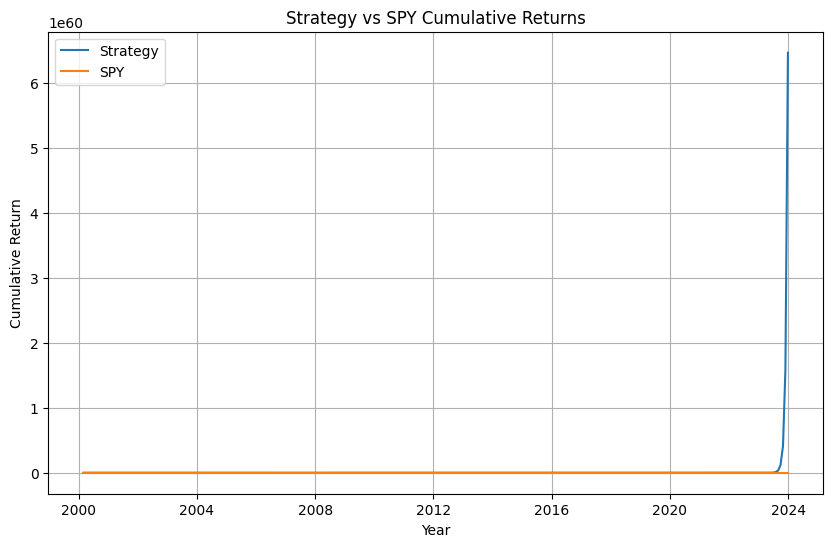

In [10]:
# Load historical SPY data
spy_data = yf.download('SPY', start='2000-01-01', end='2023-12-31')

# Resample to monthly data
spy_data['Return'] = spy_data['Adj Close'].pct_change()
spy_data['Month'] = spy_data.index.month
spy_data['Year'] = spy_data.index.year
spy_data_monthly = spy_data.resample('M').apply({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Adj Close': 'last',
    'Volume': 'sum',
    'Return': 'sum'
})



spy_data = calculate_technical_indicators(spy_data)

# Define the strategy
def apply_strategy(df):
    initial_capital = 5000  # Starting with $5,000
    capital = initial_capital
    position = 0  # No initial position
    returns = []

    for i in range(1, len(df)):
        month = df.index[i].month
        if month in [4, 7, 11]:  # Buy in April, July, and November
            if position == 0:
                position = capital / df['Adj Close'].iloc[i]
                capital = 0
        elif month in [6, 8, 9]:  # Sell in June, August, and September
            if position > 0:
                capital = position * df['Adj Close'].iloc[i]
                position = 0
        else:  # Hedge or hold
            if position > 0:
                capital = position * df['Adj Close'].iloc[i]
                position = 0
            position = capital / df['Adj Close'].iloc[i]
            capital = 0
        
        # Calculate monthly return
        total_value = capital + position * df['Adj Close'].iloc[i]
        monthly_return = (total_value - initial_capital) / initial_capital
        returns.append(monthly_return)

    # Final capital
    if position > 0:
        capital = position * df['Adj Close'].iloc[-1]

    return returns, capital

# Backtest the strategy
monthly_returns, final_capital = apply_strategy(spy_data_monthly)

# Calculate performance metrics
cumulative_returns = (1 + np.array(monthly_returns)).cumprod()
total_return = (final_capital - 5000) / 5000
annualized_return = np.mean(monthly_returns) * 12
annualized_volatility = np.std(monthly_returns) * np.sqrt(12)
sharpe_ratio = annualized_return / annualized_volatility

# Print performance metrics
print(f"Final Portfolio Value: ${final_capital:.2f}")
print(f"Total Return: {total_return * 100:.2f}%")
print(f"Annualized Return: {annualized_return * 100:.2f}%")
print(f"Annualized Volatility: {annualized_volatility * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Ensure x and y have the same length
spy_data_monthly = spy_data_monthly.iloc[1:]  # Exclude the first month for alignment

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(spy_data_monthly.index, cumulative_returns, label='Strategy')
plt.plot(spy_data_monthly.index, (spy_data_monthly['Adj Close'] / spy_data_monthly['Adj Close'].iloc[0]), label='SPY')
plt.title('Strategy vs SPY Cumulative Returns')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()


# 52 Week Strategy (Backtest)

Final Portfolio Value: $36363.04
Total Return: 627.26%
Annualized Return: 8102.59%
Annualized Volatility: 1264.02%
Sharpe Ratio: 6.41


C:\Users\Administrator\AppData\Local\Temp\ipykernel_8944\3870566138.py:45: RuntimeWarning: overflow encountered in accumulate
  cumulative_returns = (1 + np.array(weekly_returns)).cumprod()


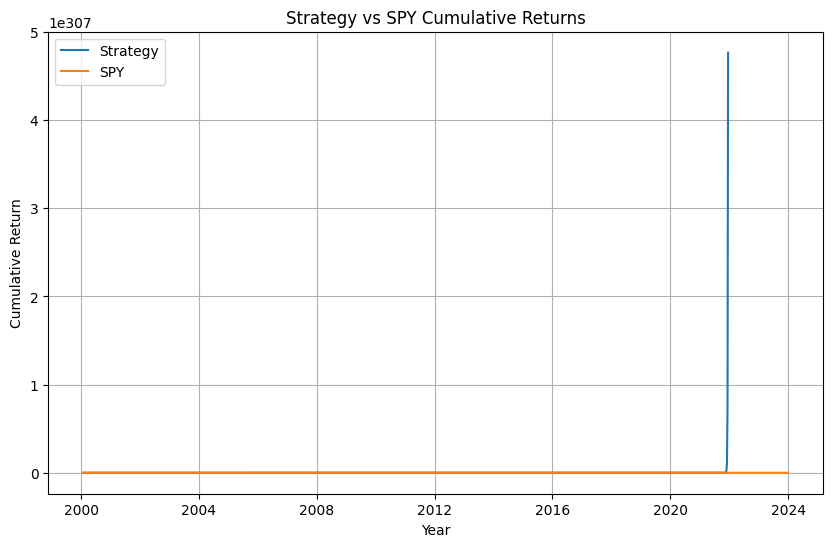

In [25]:
# Load historical SPY data
spy_data = yf.download('SPY', start='2000-01-01', end='2023-12-31')

# Calculate daily returns
spy_data['Return'] = spy_data['Adj Close'].pct_change()

# Add 'Week' and 'Year' columns before resampling
spy_data['Week'] = spy_data.index.isocalendar().week
spy_data['Year'] = spy_data.index.year

# Resample to weekly data
spy_data_weekly = spy_data.resample('W').apply({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Adj Close': 'last',
    'Volume': 'sum',
    'Return': 'sum'
})

# Re-add the 'Week' and 'Year' columns after resampling
spy_data_weekly['Week'] = spy_data_weekly.index.isocalendar().week
spy_data_weekly['Year'] = spy_data_weekly.index.year

# Define the strategy
def apply_strategy(df):
    initial_capital = 5000  # Starting with $5,000
    capital = initial_capital
    position = 0  # No initial position
    returns = []
    
    for i in range(1, len(df)):
        week = df['Week'].iloc[i]
        # Example of strategies based on specific weeks (you can adjust this)
        if week in [7, 10, 12]:  # Buy in week 7, 10, and 12
            if position == 0:
                position = capital / df['Adj Close'].iloc[i]
                capital = 0
        elif week in [24, 37]:  # Sell or hedge in weeks 24 and 37
            if position > 0:
                capital = position * df['Adj Close'].iloc[i]
                position = 0
        else:  # Hold position or implement a hedge
            if position > 0:
                capital = position * df['Adj Close'].iloc[i]
                position = 0
            position = capital / df['Adj Close'].iloc[i]
            capital = 0
        
        # Calculate weekly return
        total_value = capital + position * df['Adj Close'].iloc[i]
        weekly_return = (total_value - initial_capital) / initial_capital
        returns.append(weekly_return)

    # Final capital
    if position > 0:
        capital = position * df['Adj Close'].iloc[-1]

    return returns, capital

# Backtest the strategy
weekly_returns, final_capital = apply_strategy(spy_data_weekly)

# Calculate performance metrics
cumulative_returns = (1 + np.array(weekly_returns)).cumprod()
total_return = (final_capital - 5000) / 5000
annualized_return = np.mean(weekly_returns) * 52
annualized_volatility = np.std(weekly_returns) * np.sqrt(52)
sharpe_ratio = annualized_return / annualized_volatility

# Print performance metrics
print(f"Final Portfolio Value: ${final_capital:.2f}")
print(f"Total Return: {total_return * 100:.2f}%")
print(f"Annualized Return: {annualized_return * 100:.2f}%")
print(f"Annualized Volatility: {annualized_volatility * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Ensure x and y have the same length
spy_data_weekly = spy_data_weekly.iloc[1:]  # Exclude the first week for alignment

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(spy_data_weekly.index, cumulative_returns, label='Strategy')
plt.plot(spy_data_weekly.index, (spy_data_weekly['Adj Close'] / spy_data_weekly['Adj Close'].iloc[0]), label='SPY')
plt.title('Strategy vs SPY Cumulative Returns')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()


Final Portfolio Value: $38851.49
Total Return: 55.41%
Annualized Return: 977.81%
Annualized Volatility: 127.46%
Sharpe Ratio: 7.67


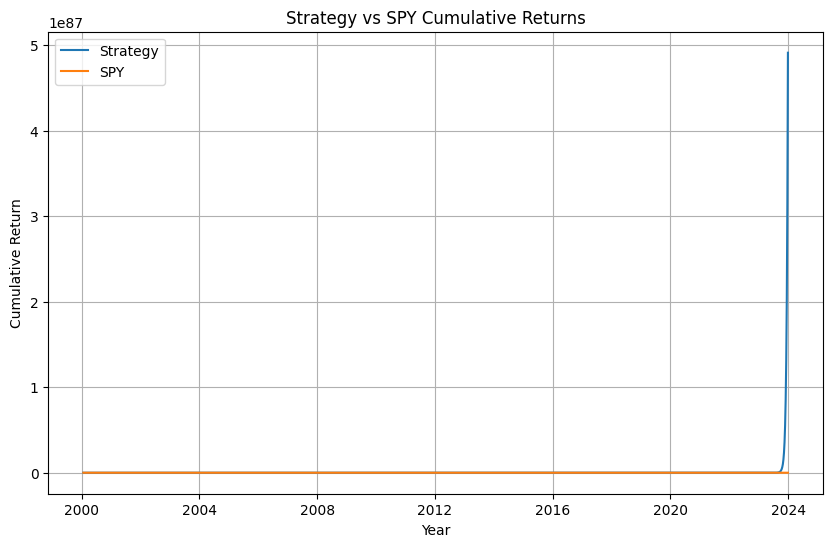

In [24]:

# Example Kelly data for each week (replace with actual Kelly fractions)
kelly_fractions = pd.Series(0.2, index=spy_data_weekly.index)  # Placeholder values, use real data here

# Define the strategy
def apply_strategy(df, kelly_fractions):
    initial_capital = 25000  # Starting with $25,000
    capital = initial_capital
    position = 0  # No initial position
    returns = []

    for i in range(1, len(df)):
        week = df['Week'].iloc[i]
        kelly_fraction = kelly_fractions.iloc[i]
        
        if week in [7, 10, 12]:  # Buy in week 7, 10, and 12
            if position == 0:
                position_size = capital * kelly_fraction
                position = position_size / df['Adj Close'].iloc[i]
                capital -= position_size
        elif week in [24, 37]:  # Sell or hedge in weeks 24 and 37
            if position > 0:
                capital += position * df['Adj Close'].iloc[i]
                position = 0
        else:  # Hold position or implement a hedge
            if position > 0:
                capital += position * df['Adj Close'].iloc[i]
                position = 0
            position_size = capital * kelly_fraction
            position = position_size / df['Adj Close'].iloc[i]
            capital -= position_size
        
        # Calculate weekly return
        total_value = capital + position * df['Adj Close'].iloc[i]
        weekly_return = (total_value - initial_capital) / initial_capital
        returns.append(weekly_return)

    # Final capital
    if position > 0:
        capital += position * df['Adj Close'].iloc[-1]

    return returns, capital

# Backtest the strategy
weekly_returns, final_capital = apply_strategy(spy_data_weekly, kelly_fractions)

# Calculate performance metrics
cumulative_returns = (1 + np.array(weekly_returns)).cumprod()
total_return = (final_capital - 25000) / 25000
annualized_return = np.mean(weekly_returns) * 52
annualized_volatility = np.std(weekly_returns) * np.sqrt(52)
sharpe_ratio = annualized_return / annualized_volatility

# Print performance metrics
print(f"Final Portfolio Value: ${final_capital:.2f}")
print(f"Total Return: {total_return * 100:.2f}%")
print(f"Annualized Return: {annualized_return * 100:.2f}%")
print(f"Annualized Volatility: {annualized_volatility * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Ensure x and y have the same length
spy_data_weekly = spy_data_weekly.iloc[1:]  # Exclude the first week for alignment

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(spy_data_weekly.index, cumulative_returns, label='Strategy')
plt.plot(spy_data_weekly.index, (spy_data_weekly['Adj Close'] / spy_data_weekly['Adj Close'].iloc[0]), label='SPY')
plt.title('Strategy vs SPY Cumulative Returns')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()
